In [58]:
import pandas as pd

In [59]:
sigma = 40.00
filename = f"../logs/length_analysis/length_summaries_{sigma:.2f}.csv"
summaries = pd.read_csv(filename)
summaries.describe()

In [17]:
## Create bins for 'n' in groups of 10
#summaries["n_group"] = pd.cut(summaries["n"], bins=range(0, 130, 10), right=False)
#
#
## Create a FacetGrid to plot hexbin plots for each group of 'n_group'
#g = sns.FacetGrid(
#    summaries, col="n_group", col_wrap=4, height=4, sharex=True, sharey=False
#)
#
## Define a function to plot hexbin with a color bar
#def hexbin_with_colorbar(data, **kwargs):
#    hb = plt.hexbin(data['t'], data['m'], gridsize=50, cmap='viridis', **kwargs)
#    plt.colorbar(hb, ax=plt.gca(), label='Counts')
#
## Map the hexbin plot function to the FacetGrid
#g.map_dataframe(hexbin_with_colorbar)
#
## Set axis labels and limits
#g.set_axis_labels("t", "m")
##g.set(ylim=(0, 130))  # Set y-axis limits
#g.add_legend()
#
## Add grid lines
#for ax in g.axes.flat:
#    ax.set_xlim(0, 1)  # Ensure x-axis is limited to 0 to 1
#    ax.grid(True)
#
#plt.show()

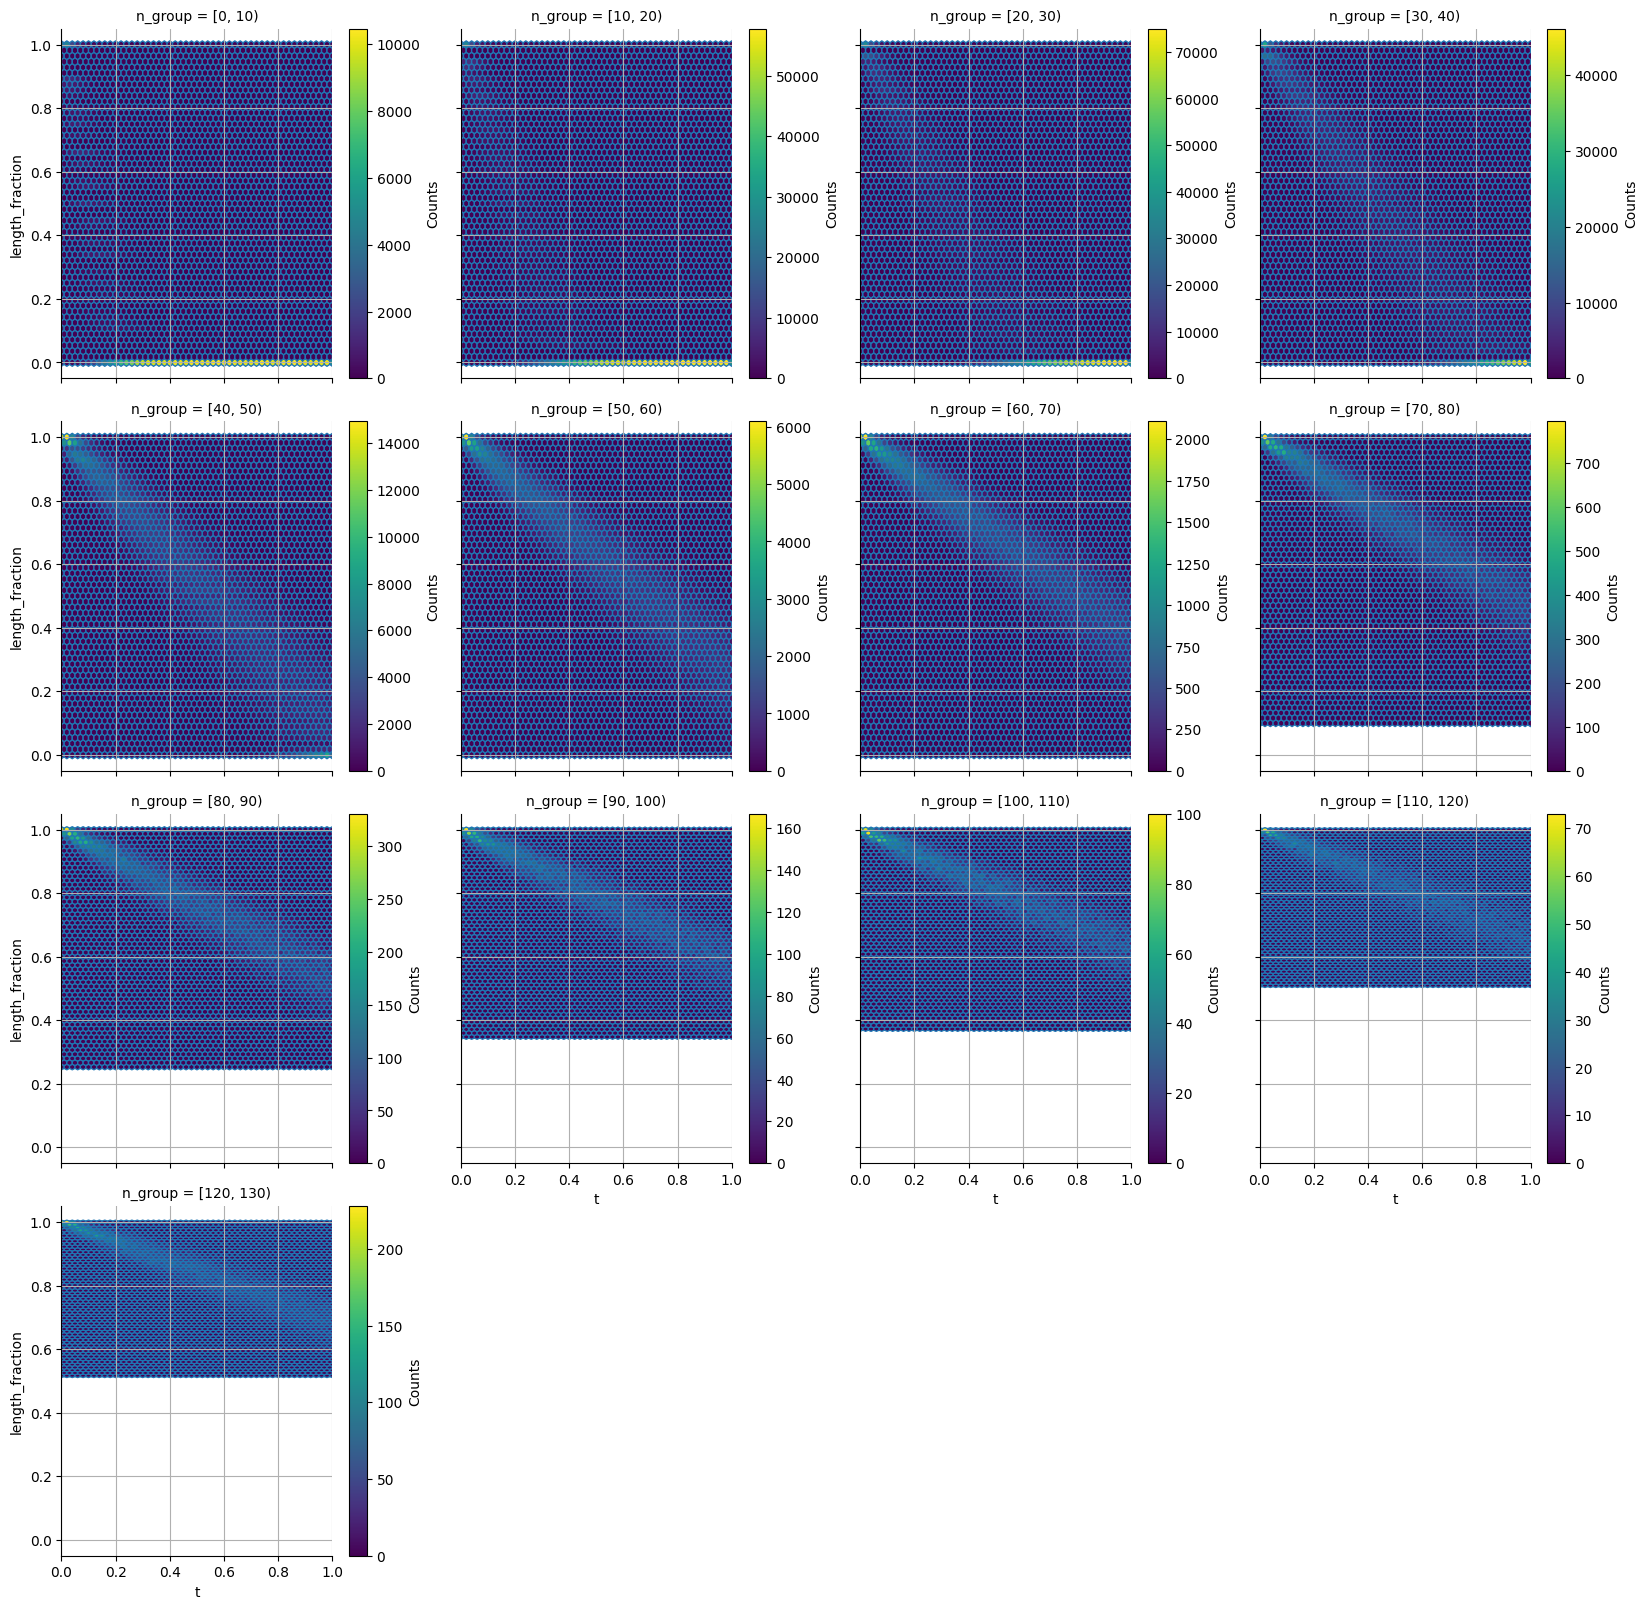

<Figure size 640x480 with 0 Axes>

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
summaries["n"] = summaries["n"] - 1
summaries["m"] = summaries["m"] - 1

summaries["length_fraction"] = summaries["m"] / summaries["n"]
# Create bins for 'n' in groups of 10
summaries["n_group"] = pd.cut(summaries["n"], bins=range(0, 140, 10), right=False)


# Create a FacetGrid to plot hexbin plots for each group of 'n_group'
g = sns.FacetGrid(
    summaries, col="n_group", col_wrap=4, height=4, sharex=True, sharey=True
)

# Define a function to plot hexbin with a color bar
def hexbin_with_colorbar(data, **kwargs):
    hb = plt.hexbin(data['t'], data['length_fraction'], gridsize=50, cmap='viridis', **kwargs)
    plt.colorbar(hb, ax=plt.gca(), label='Counts')

# Map the hexbin plot function to the FacetGrid
g.map_dataframe(hexbin_with_colorbar)

# Set axis labels and limits
g.set_axis_labels("t", "length_fraction")
#g.set(ylim=(0, 130))  # Set y-axis limits
g.add_legend()

# Add grid lines
for ax in g.axes.flat:
    ax.set_xlim(0, 1)  # Ensure x-axis is limited to 0 to 1
    ax.grid(True)

plt.show()
plt.savefig(f"../logs/length_analysis/length_analysis_{sigma:.2f}.pdf")



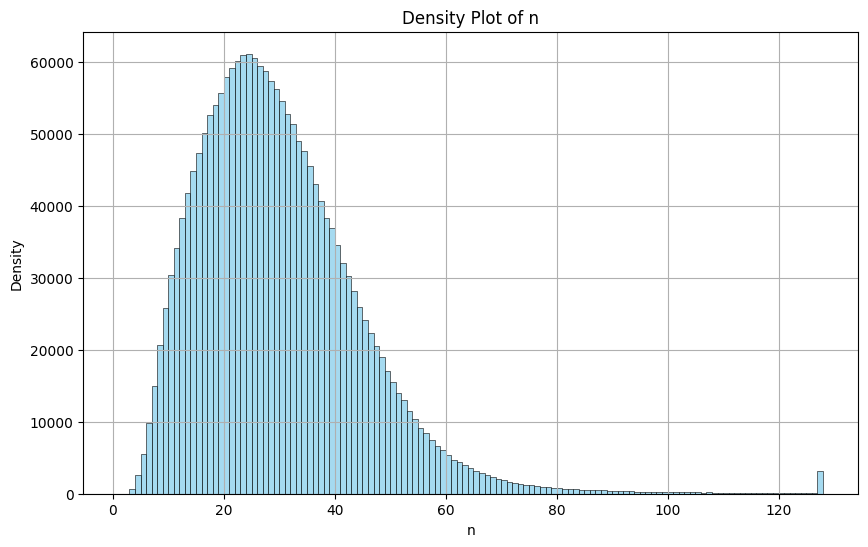

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Plot a density plot for 'n'
plt.figure(figsize=(10, 6))
sns.histplot(summaries['n'], color='skyblue', fill=True, bins=range(1, 129, 1), stat="count")
plt.title('Density Plot of n')
plt.xlabel('n')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# LM1B

In [1]:
import datasets
tokenized = datasets.load_from_disk('/work/pi_mccallum_umass_edu/dhruveshpate_umass_edu/diffusion/data/lm1b/train')
def length(example):
    example["length"] = min(len(example["token_ids"]), 128)
    return example
all_lengths = tokenized.map(length, batched=False, num_proc=8, remove_columns=["token_ids"])

Loading dataset from disk:   0%|          | 0/256 [00:00<?, ?it/s]

Map (num_proc=8):   0%|          | 0/30301028 [00:00<?, ? examples/s]

In [2]:
import numpy as np
N = 1000000
ids = np.random.permutation(len(all_lengths))[:N]
lengths = all_lengths.select(ids)

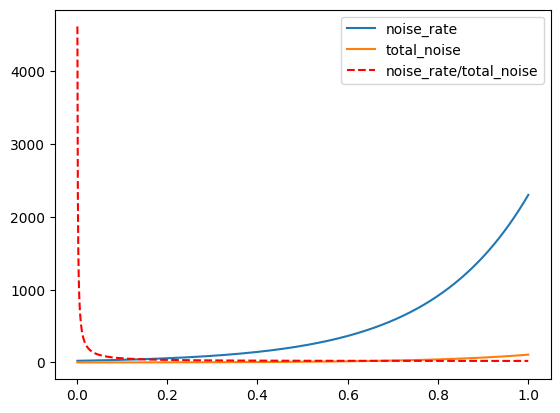

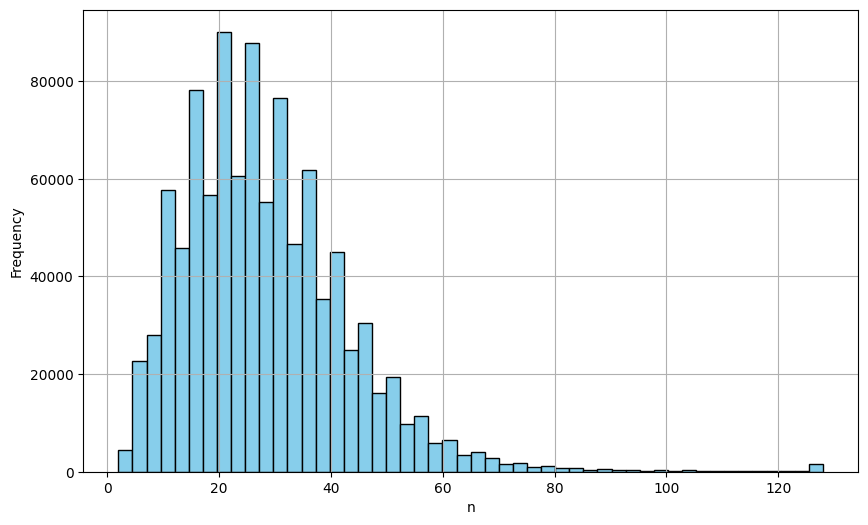

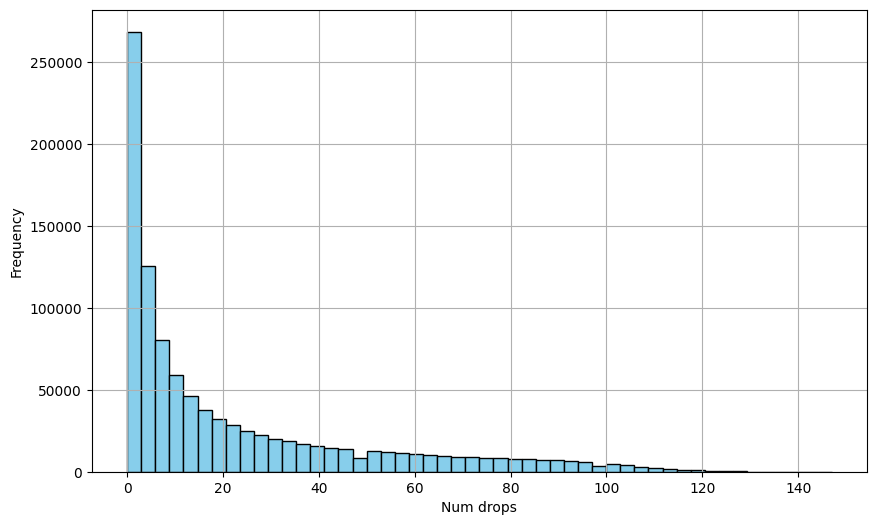

Fraction with zero drops: 0.121486


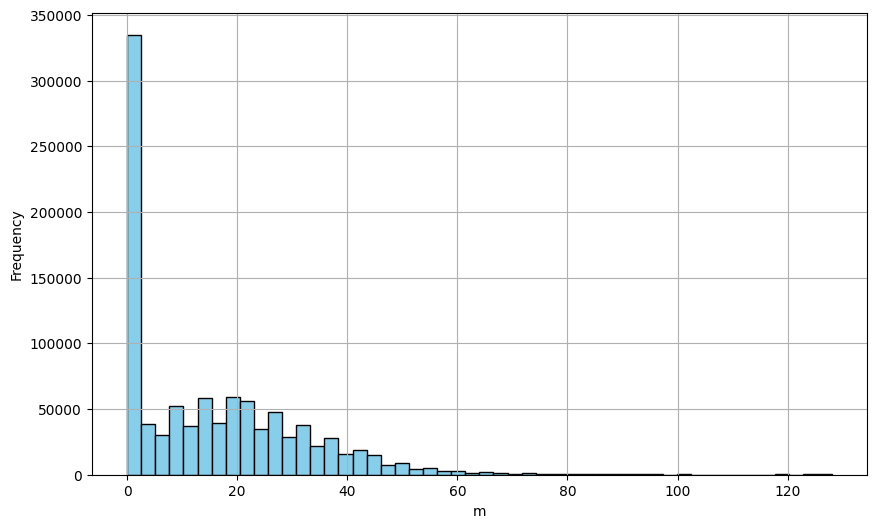

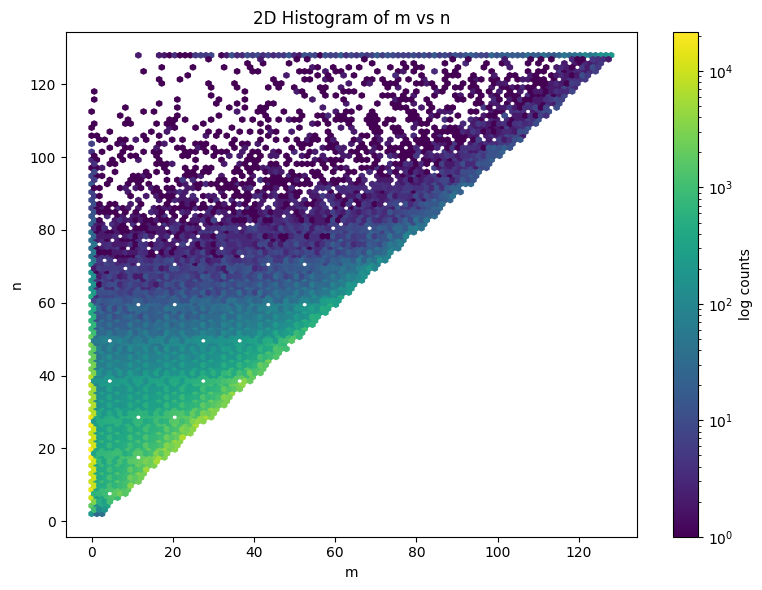

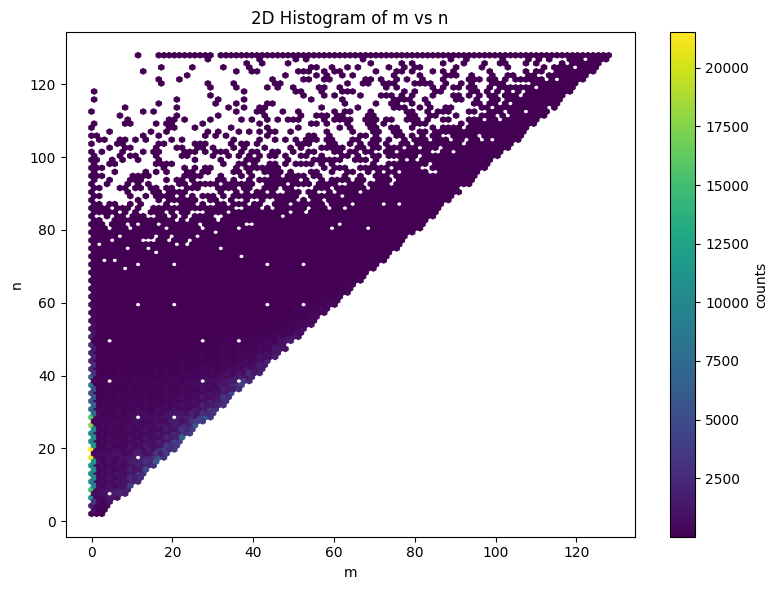

In [3]:
from pcdd.noise_schedule.idlm import LogLinearNoiseSchedule, GeometricNoiseSchedule
import torch

import matplotlib.pyplot as plt
eps = 1e-3
#noise_schedule = LogLinearNoiseSchedule(sigma_min=10, sigma_max=500)
noise_schedule = LogLinearNoiseSchedule(sigma_min=5, sigma_max=500, eps=eps)
t = torch.linspace(eps, 1.0, 1000)
noise_rate, total_noise = noise_schedule(t)
plt.plot(t, noise_rate, label='noise_rate')
plt.plot(t, total_noise, label='total_noise')
plt.plot(t, noise_rate/total_noise, label='noise_rate/total_noise', color='red', linestyle='--')
plt.legend()
plt.show()


t = noise_schedule.sample_t(len(lengths))
noise_rate, total_noise = noise_schedule(t)
n_drops = torch.poisson(total_noise)
lengths_tensor = torch.tensor(lengths["length"])
m = torch.maximum(lengths_tensor - n_drops, torch.tensor([0]))



plt.figure(figsize=(10, 6))
plt.hist(lengths_tensor.numpy(), bins=50, color="skyblue", edgecolor="black")
plt.xlabel("n")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(n_drops.numpy(), bins=50, color="skyblue", edgecolor="black")
plt.xlabel("Num drops")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

print(f"Fraction with zero drops: {torch.sum(n_drops == 0).item()/len(n_drops)}")

plt.figure(figsize=(10, 6))
plt.hist(m.numpy(), bins=50, color="skyblue", edgecolor="black")
plt.xlabel("m")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


y = lengths_tensor.detach().cpu().numpy()
x = m.detach().cpu().numpy()

# 3a. Using hist2d
from matplotlib.colors import LogNorm
plt.figure(figsize=(8,6))
#hb = plt.hist2d(x, y, bins=100, norm=LogNorm(vmin=1))    # you can tweak bins
#plt.colorbar(hb[3], label='counts')
hb = plt.hexbin(x, y, gridsize=100, bins='log', mincnt=1)
plt.colorbar(hb, label='log counts')
plt.xlabel('m')
plt.ylabel('n')
plt.title('2D Histogram of m vs n')
plt.tight_layout()
plt.show()


# 3a. Using hist2d
from matplotlib.colors import LogNorm
plt.figure(figsize=(8,6))
#hb = plt.hist2d(x, y, bins=100, norm=LogNorm(vmin=1))    # you can tweak bins
#plt.colorbar(hb[3], label='counts')
hb = plt.hexbin(x, y, gridsize=100, mincnt=1)
plt.colorbar(hb, label='counts')
plt.xlabel('m')
plt.ylabel('n')
plt.title('2D Histogram of m vs n')
plt.tight_layout()
plt.show()

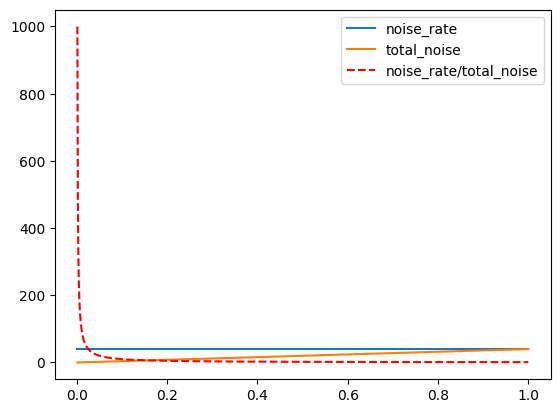

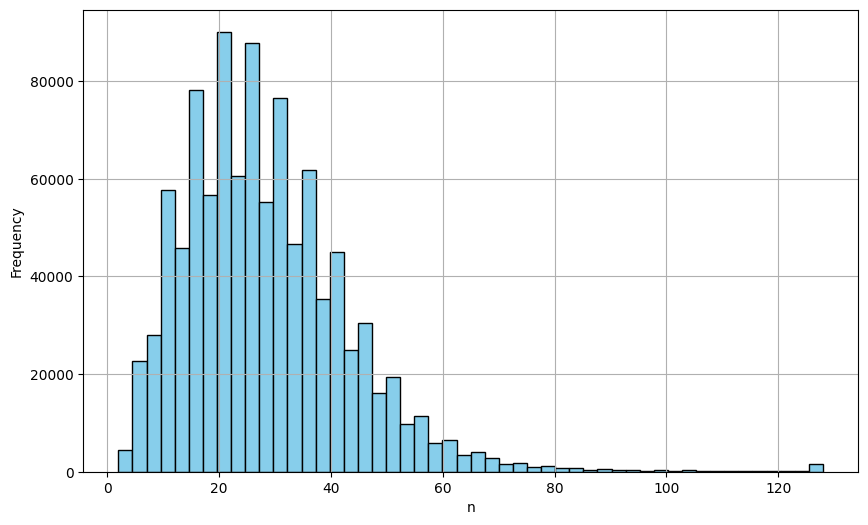

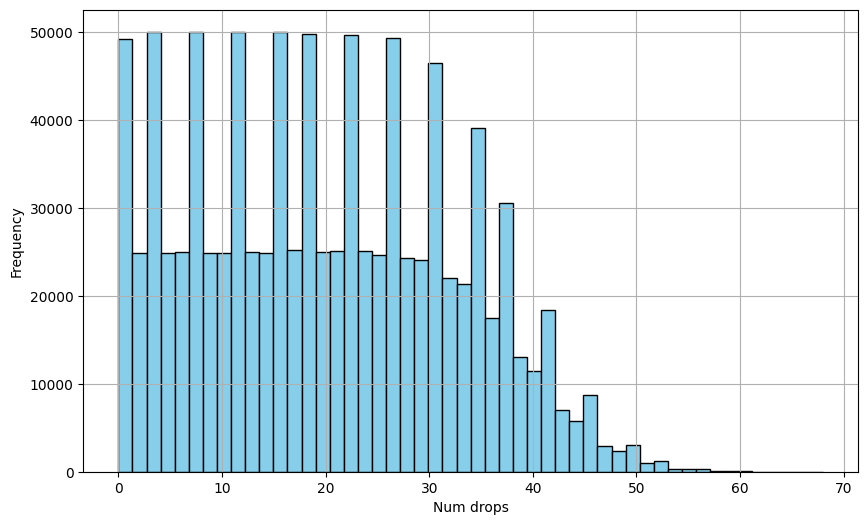

Fraction with zero drops: 0.024095


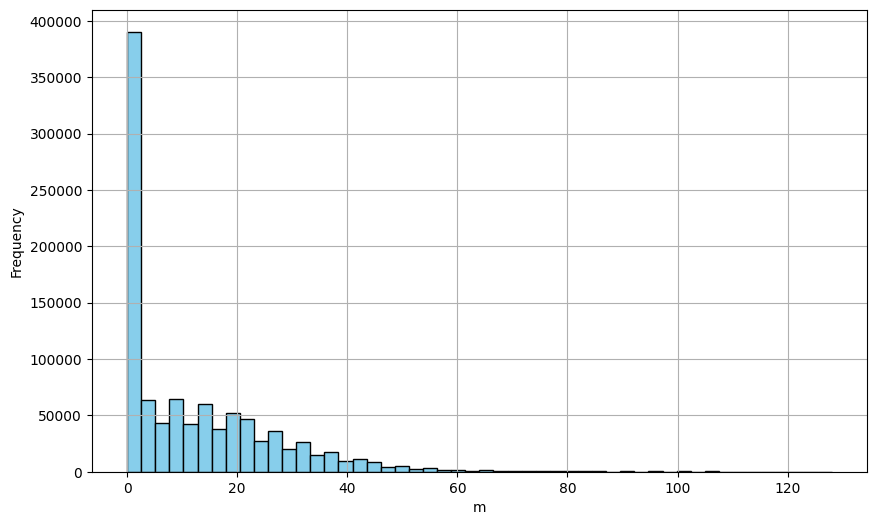

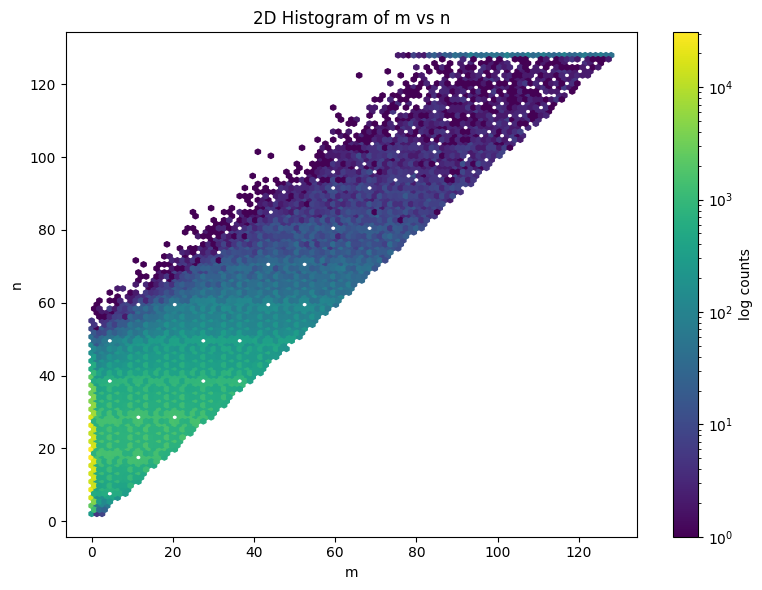

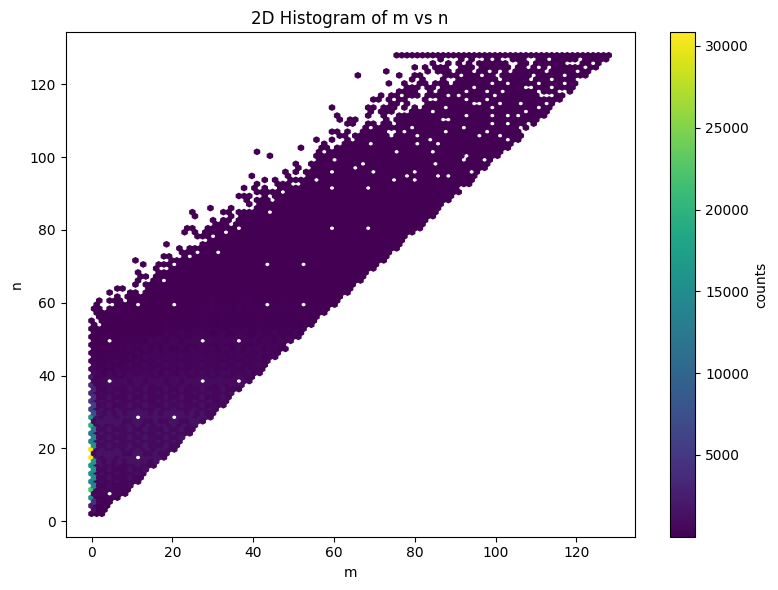

In [7]:
from pcdd.noise_schedule.idlm import LogLinearNoiseSchedule, PoissonNoiseSchedule
import torch

import matplotlib.pyplot as plt
eps = 1e-3
#noise_schedule = LogLinearNoiseSchedule(sigma_min=10, sigma_max=500)
#noise_schedule = LogLinearNoiseSchedule(sigma_min=5, sigma_max=500, eps=eps)
noise_schedule = PoissonNoiseSchedule(sigma=40)
t = torch.linspace(eps, 1.0, 1000)
noise_rate, total_noise = noise_schedule(t)
plt.plot(t, noise_rate, label='noise_rate')
plt.plot(t, total_noise, label='total_noise')
plt.plot(t, noise_rate/total_noise, label='noise_rate/total_noise', color='red', linestyle='--')
plt.legend()
plt.show()


t = noise_schedule.sample_t(len(lengths))
noise_rate, total_noise = noise_schedule(t)
n_drops = torch.poisson(total_noise)
lengths_tensor = torch.tensor(lengths["length"])
m = torch.maximum(lengths_tensor - n_drops, torch.tensor([0]))



plt.figure(figsize=(10, 6))
plt.hist(lengths_tensor.numpy(), bins=50, color="skyblue", edgecolor="black")
plt.xlabel("n")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(n_drops.numpy(), bins=50, color="skyblue", edgecolor="black")
plt.xlabel("Num drops")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

print(f"Fraction with zero drops: {torch.sum(n_drops == 0).item()/len(n_drops)}")

plt.figure(figsize=(10, 6))
plt.hist(m.numpy(), bins=50, color="skyblue", edgecolor="black")
plt.xlabel("m")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


y = lengths_tensor.detach().cpu().numpy()
x = m.detach().cpu().numpy()

# 3a. Using hist2d
from matplotlib.colors import LogNorm
plt.figure(figsize=(8,6))
#hb = plt.hist2d(x, y, bins=100, norm=LogNorm(vmin=1))    # you can tweak bins
#plt.colorbar(hb[3], label='counts')
hb = plt.hexbin(x, y, gridsize=100, bins='log', mincnt=1)
plt.colorbar(hb, label='log counts')
plt.xlabel('m')
plt.ylabel('n')
plt.title('2D Histogram of m vs n')
plt.tight_layout()
plt.show()


# 3a. Using hist2d
from matplotlib.colors import LogNorm
plt.figure(figsize=(8,6))
#hb = plt.hist2d(x, y, bins=100, norm=LogNorm(vmin=1))    # you can tweak bins
#plt.colorbar(hb[3], label='counts')
hb = plt.hexbin(x, y, gridsize=100, mincnt=1)
plt.colorbar(hb, label='counts')
plt.xlabel('m')
plt.ylabel('n')
plt.title('2D Histogram of m vs n')
plt.tight_layout()
plt.show()

# Stories

In [1]:
import datasets

In [2]:
stories = datasets.load_dataset("dhruveshpatel/tiny_roc_stories", split="train")

In [3]:
tokenized = datasets.load_from_disk('/work/pi_mccallum_umass_edu/dhruveshpate_umass_edu/diffusion/data/dhruveshpatel/tiny_roc_stories/train')
def length(example):
    example["length"] = len(example["token_ids"])
    return example
lengths = tokenized.map(length, batched=False, num_proc=8)

Loading dataset from disk:   0%|          | 0/256 [00:00<?, ?it/s]

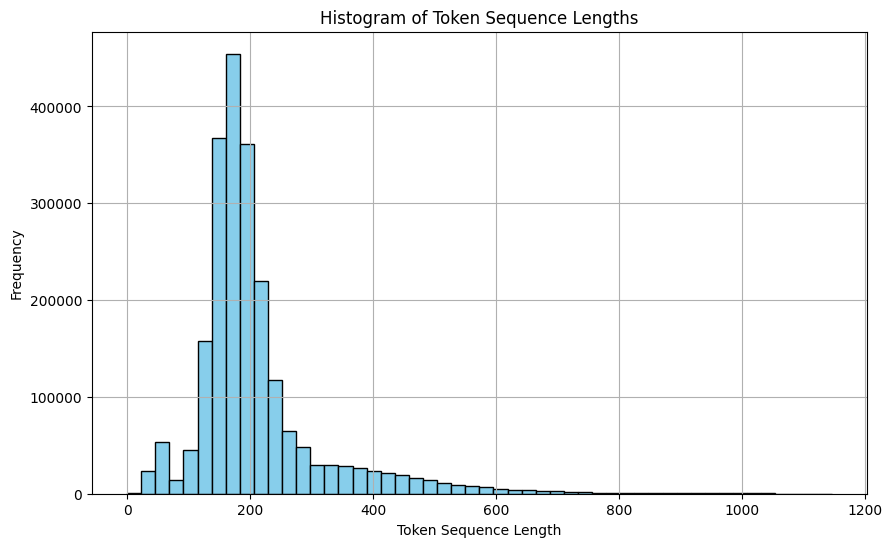

In [4]:
# Plot a histogram for the 'length' field of the HF dataset
import matplotlib.pyplot as plt

# Extract the "length" values from the dataset (this will be a list)
length_values = lengths["length"]

plt.figure(figsize=(10, 6))
plt.hist(length_values, bins=50, color="skyblue", edgecolor="black")
plt.xlabel("Token Sequence Length")
plt.ylabel("Frequency")
plt.title("Histogram of Token Sequence Lengths")
plt.grid(True)
plt.show()

In [5]:
long = lengths.filter(lambda x: x["length"] > 1000, num_proc=8)

In [6]:
from pcdd.datamodule.datamodule import BertTokenizerForILMFast
tokenizer = BertTokenizerForILMFast.from_pretrained("bert-base-uncased")

KeyboardInterrupt: 

In [25]:
import textwrap
text = tokenizer.decode(long['token_ids'][1])
print(textwrap.fill(text, width=100))


lily had a diary. she liked to write in it every day. she wrote about her friends, her toys, her
dreams. she drew pictures of flowers, stars, and animals. she used many colors to make her diary
pretty. one day, it was very hot. lily wanted to play outside, but her mom said no. it was too hot
and sunny. lily had to stay inside. she was bored and sad. she looked for her diary, but she could
not find it. she asked her mom, but her mom did not know. " maybe you left it in your room, " her
mom said. " go and look there. " lily went to her room. she looked under her bed, in her closet, on
her shelf. she did not see her diary. she felt scared. what if she lost it? what if someone took it?
she hoped her diary was safe. she heard a noise. it was her brother, tom. he came out of his room.
he had something in his hand. it was lily ' s diary! " tom, give me my diary! " lily shouted. " that
is mine! " tom laughed. he ran away with the diary. he said, " no, this is mine now. i want to see
what you w

# Loglinear

In [1]:
from pcdd.noise_schedule.idlm import LogLinearNoiseSchedule, GeometricNoiseSchedule
import torch
import datasets

tokenized = datasets.load_from_disk('/work/pi_mccallum_umass_edu/dhruveshpate_umass_edu/diffusion/data/dhruveshpatel/tiny_roc_stories/train')
def length(example):
    example["length"] = len(example["token_ids"])
    return example
lengths = tokenized.map(length, batched=False, num_proc=8)
# filter out lengths = 0
lengths = lengths.filter(lambda x: x["length"] > 0, num_proc=8)


Loading dataset from disk:   0%|          | 0/256 [00:00<?, ?it/s]

Filter (num_proc=8):   0%|          | 0/2198247 [00:00<?, ? examples/s]

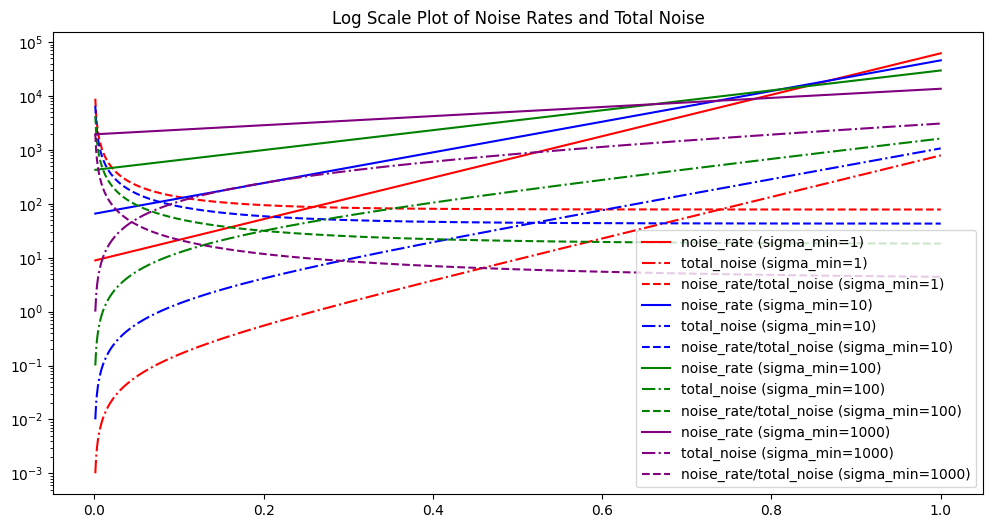

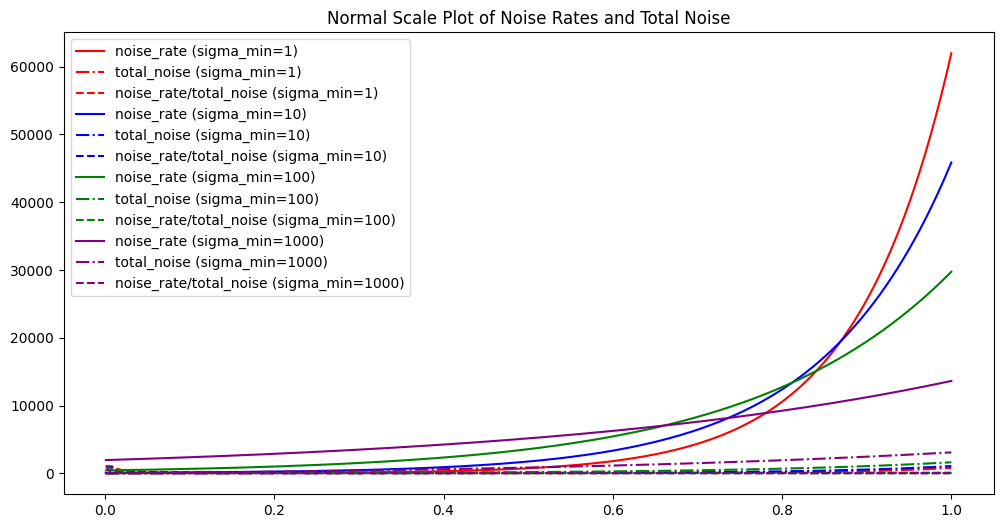

In [2]:
import torch
import matplotlib.pyplot as plt
t = torch.linspace(1e-3, 1.0, 1000)
colors = ['red', 'blue', 'green', 'purple']
plt.figure(figsize=(12, 6))
for sigma_min, color in zip([1, 10, 100, 1000], colors):
    noise_schedule = LogLinearNoiseSchedule(sigma_min=sigma_min, sigma_max=7000, eps=1e-3)
    noise_rate, total_noise = noise_schedule(t)
    ratio = (noise_rate / total_noise)
    plt.plot(t, noise_rate, label=f'noise_rate (sigma_min={sigma_min})', color=color)
    plt.plot(t, total_noise, label=f'total_noise (sigma_min={sigma_min})', linestyle='-.', color=color)
    plt.plot(t, ratio, label=f'noise_rate/total_noise (sigma_min={sigma_min})', linestyle='--', color=color)
plt.yscale('log')
plt.legend()
plt.title('Log Scale Plot of Noise Rates and Total Noise')
plt.show()

plt.figure(figsize=(12, 6))
for sigma_min, color in zip([1, 10, 100, 1000], colors):
    noise_schedule = LogLinearNoiseSchedule(sigma_min=sigma_min, sigma_max=7000)
    noise_rate, total_noise = noise_schedule(t)
    ratio = (noise_rate / total_noise).clamp(max=1000)
    plt.plot(t, noise_rate, label=f'noise_rate (sigma_min={sigma_min})', color=color)
    plt.plot(t, total_noise, label=f'total_noise (sigma_min={sigma_min})', linestyle='-.', color=color)
    plt.plot(t, ratio, label=f'noise_rate/total_noise (sigma_min={sigma_min})', linestyle='--', color=color)
plt.legend()
plt.title('Normal Scale Plot of Noise Rates and Total Noise')
plt.show()



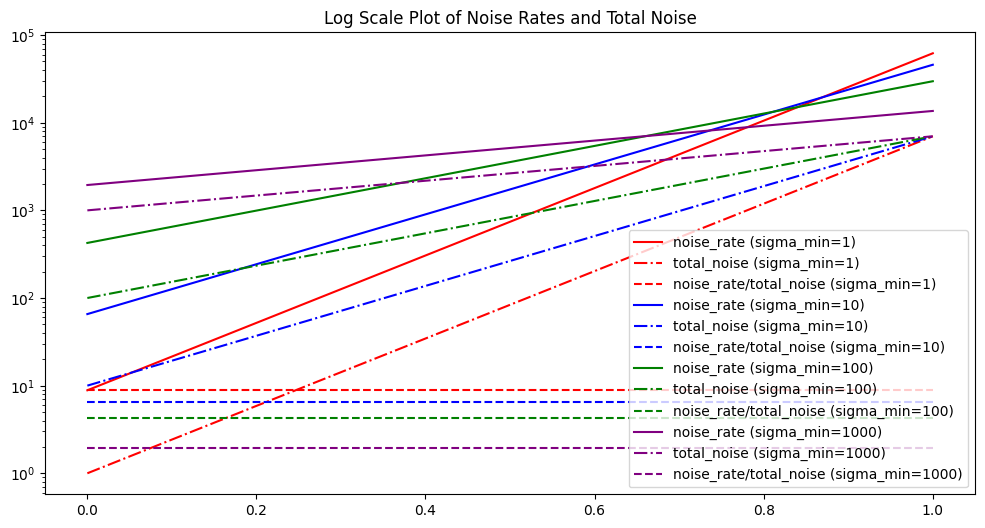

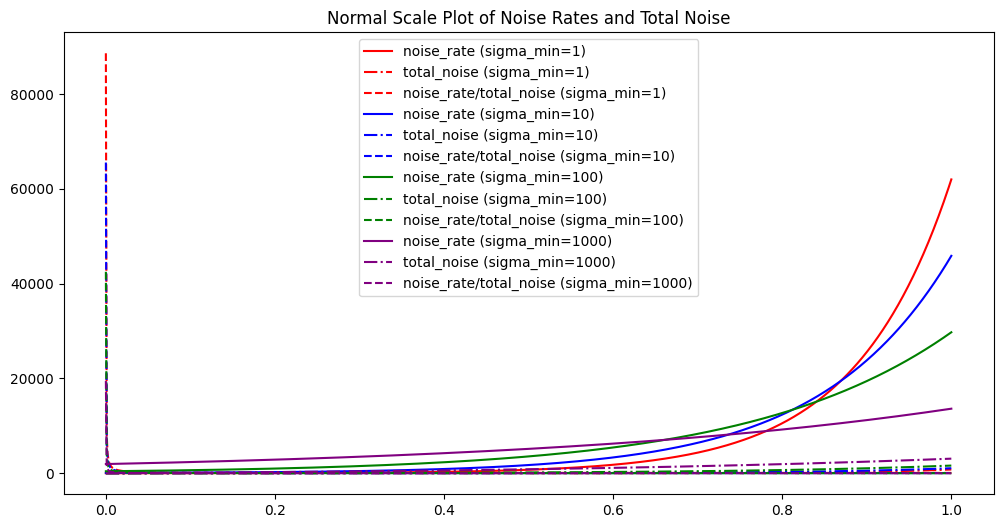

In [4]:
from pcdd.noise_schedule.idlm import GeometricNoiseSchedule
t = torch.linspace(1e-4, 1.0, 1000)
colors = ['red', 'blue', 'green', 'purple']
plt.figure(figsize=(12, 6))
for sigma_min, color in zip([1, 10, 100, 1000], colors):
    noise_schedule = GeometricNoiseSchedule(sigma_min=sigma_min, sigma_max=7000)
    noise_rate, total_noise = noise_schedule(t)
    ratio = (noise_rate / total_noise)
    plt.plot(t, noise_rate, label=f'noise_rate (sigma_min={sigma_min})', color=color)
    plt.plot(t, total_noise, label=f'total_noise (sigma_min={sigma_min})', linestyle='-.', color=color)
    plt.plot(t, ratio, label=f'noise_rate/total_noise (sigma_min={sigma_min})', linestyle='--', color=color)
plt.yscale('log')
plt.legend()
plt.title('Log Scale Plot of Noise Rates and Total Noise')
plt.show()

plt.figure(figsize=(12, 6))
for sigma_min, color in zip([1, 10, 100, 1000], colors):
    noise_schedule = LogLinearNoiseSchedule(sigma_min=sigma_min, sigma_max=7000)
    noise_rate, total_noise = noise_schedule(t)
    ratio = (noise_rate / total_noise)
    plt.plot(t, noise_rate, label=f'noise_rate (sigma_min={sigma_min})', color=color)
    plt.plot(t, total_noise, label=f'total_noise (sigma_min={sigma_min})', linestyle='-.', color=color)
    plt.plot(t, ratio, label=f'noise_rate/total_noise (sigma_min={sigma_min})', linestyle='--', color=color)
plt.legend()
plt.title('Normal Scale Plot of Noise Rates and Total Noise')
plt.show()

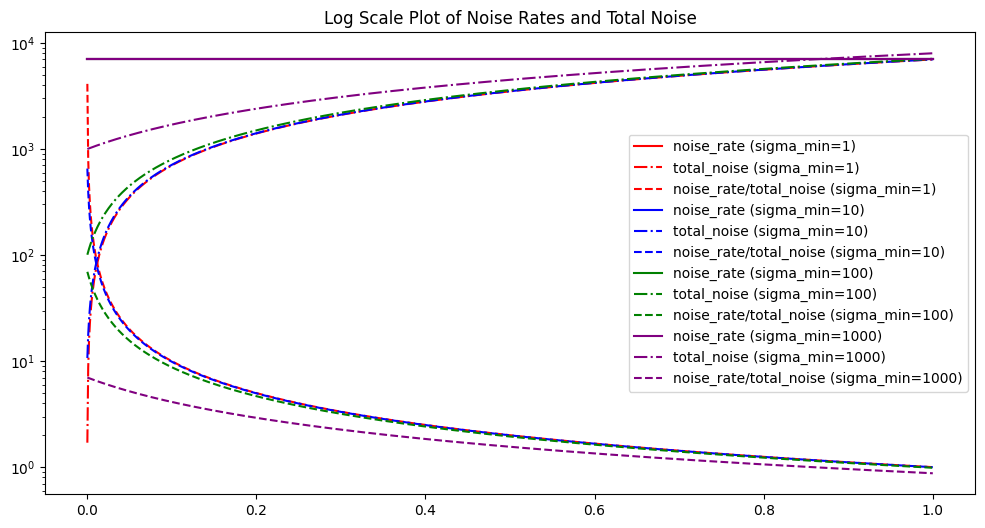

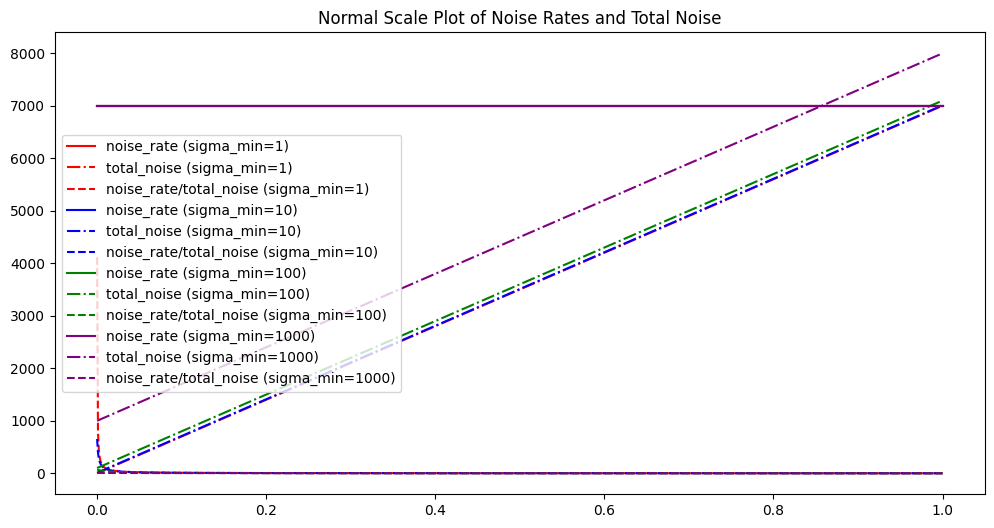

In [1]:
from pcdd.noise_schedule.idlm import PoissonNoiseSchedule
import torch
import matplotlib.pyplot as plt
t = torch.linspace(1e-4, 1.0, 1000)
colors = ['red', 'blue', 'green', 'purple']
plt.figure(figsize=(12, 6))
for sigma_min, color in zip([1, 10, 100, 1000], colors):
    noise_schedule = PoissonNoiseSchedule(c=sigma_min, sigma=7000)
    noise_rate, total_noise = noise_schedule(t)
    ratio = (noise_rate / total_noise)
    plt.plot(t, noise_rate, label=f'noise_rate (sigma_min={sigma_min})', color=color)
    plt.plot(t, total_noise, label=f'total_noise (sigma_min={sigma_min})', linestyle='-.', color=color)
    plt.plot(t, ratio, label=f'noise_rate/total_noise (sigma_min={sigma_min})', linestyle='--', color=color)
plt.yscale('log')
plt.legend()
plt.title('Log Scale Plot of Noise Rates and Total Noise')
plt.show()

plt.figure(figsize=(12, 6))
for sigma_min, color in zip([1, 10, 100, 1000], colors):
    noise_schedule = PoissonNoiseSchedule(c=sigma_min, sigma=7000)
    noise_rate, total_noise = noise_schedule(t)
    ratio = (noise_rate / total_noise)
    plt.plot(t, noise_rate, label=f'noise_rate (sigma_min={sigma_min})', color=color)
    plt.plot(t, total_noise, label=f'total_noise (sigma_min={sigma_min})', linestyle='-.', color=color)
    plt.plot(t, ratio, label=f'noise_rate/total_noise (sigma_min={sigma_min})', linestyle='--', color=color)
plt.legend()
plt.title('Normal Scale Plot of Noise Rates and Total Noise')
plt.show()

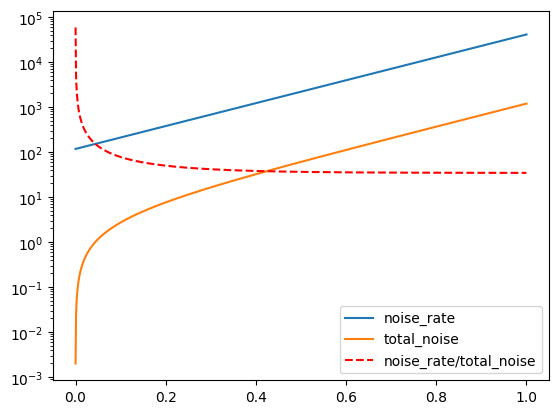

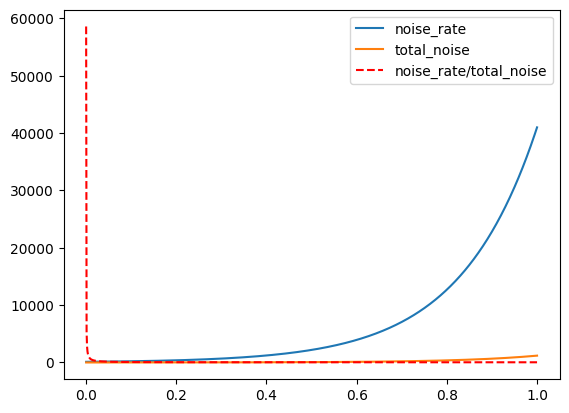

tensor(58601.6094)
tensor(36.2466)
tensor(34.4137)


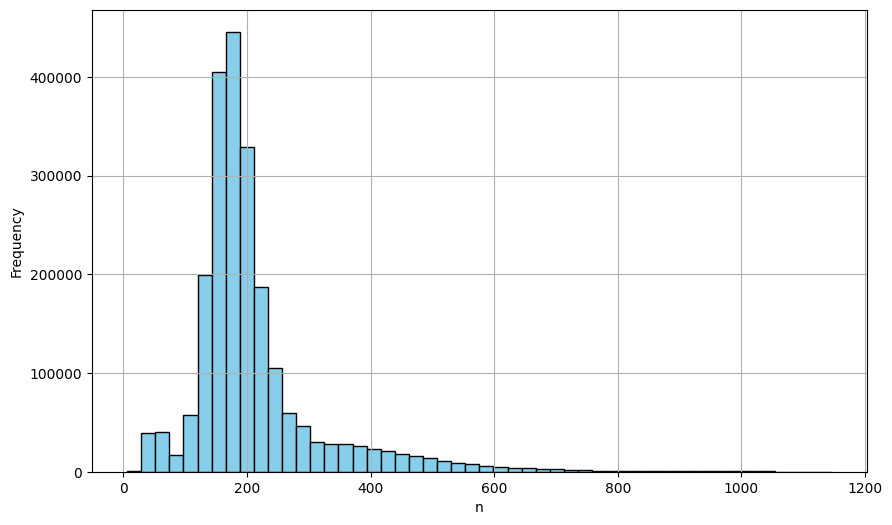

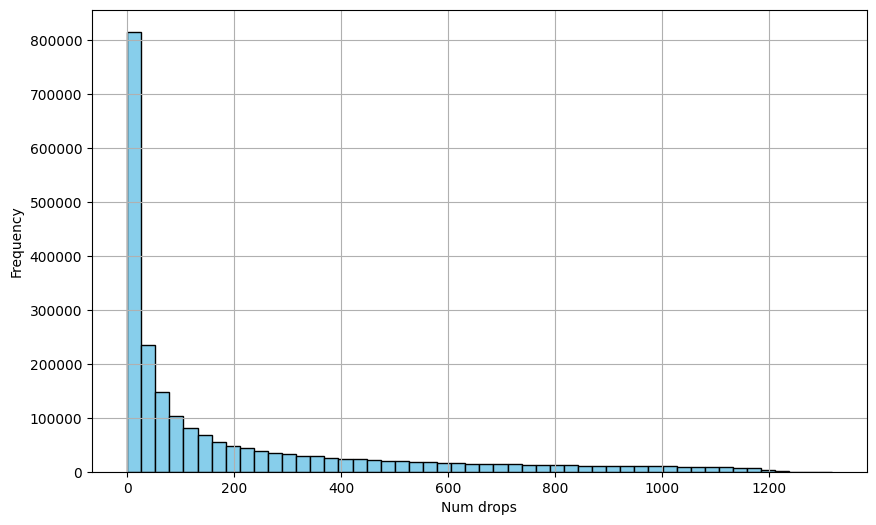

Fraction with zero drops: 0.039992866297212444


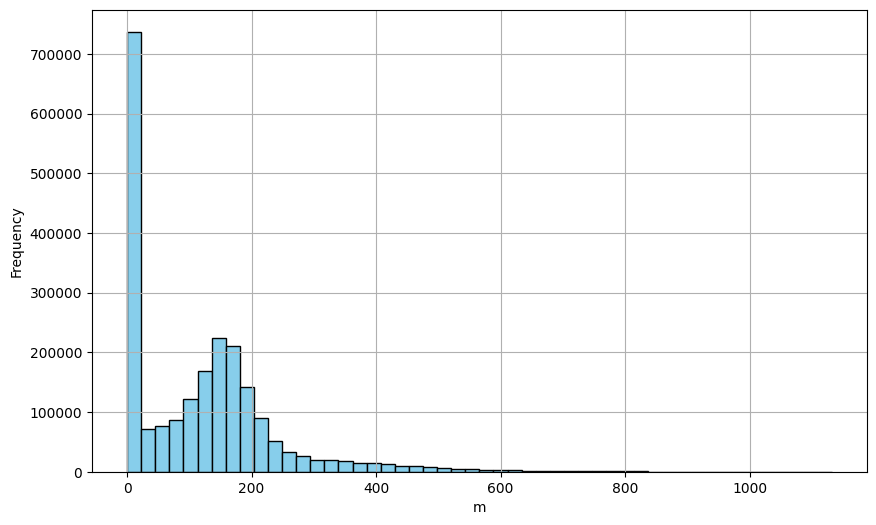

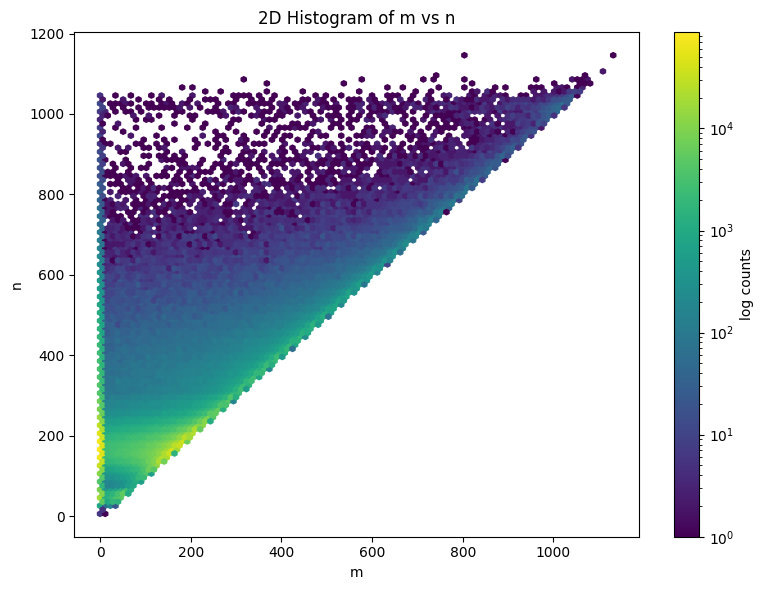

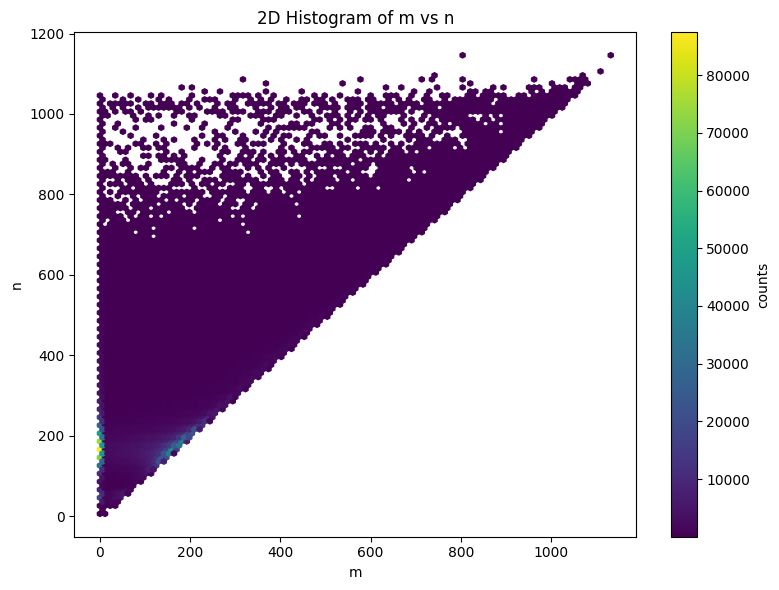

Fraction with m=0: 0.31157493591308594
max wt: 58175.75, total_noise: 0.0020150630734860897, n: 176, m: 176.0, S_: 1.0000114440917969
min wt: 1.1800315709373654e-29
min wt: 1.1800315709373654e-29, total_noise: 688.6234130859375, n: 11, m: 0.0, S_: 2.9224228219505456e+30


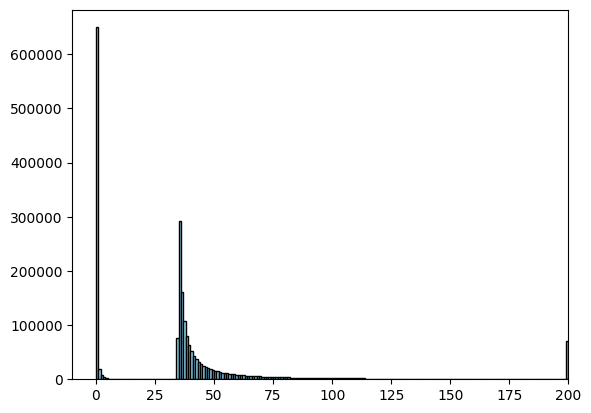

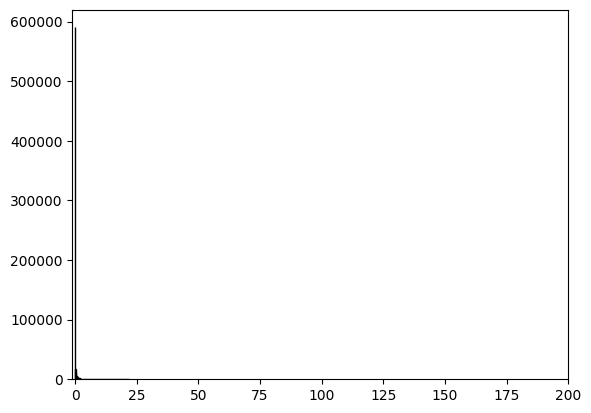

In [2]:
import matplotlib.pyplot as plt
from pcdd.noise_schedule.idlm import (
    LogLinearNoiseSchedule,
    PoissonNoiseSchedule,
)
from pcdd.utils.nn import hyp1f1_1_nplus1_vec

# noise_schedule = LogLinearNoiseSchedule(sigma_min=10, sigma_max=500)
eps = 1e-4
noise_schedule = LogLinearNoiseSchedule(sigma_min=20, sigma_max=7000, eps=eps)
# noise_schedule = PoissonNoiseSchedule(c=0, sigma=500)
t = torch.linspace(eps, 1.0, 1000)
noise_rate, total_noise = noise_schedule(t)
plt.plot(t, noise_rate, label="noise_rate")
plt.plot(t, total_noise, label="total_noise")
ratio = noise_rate / total_noise
plt.plot(t, ratio, label="noise_rate/total_noise", color="red", linestyle="--")
plt.yscale("log")
plt.legend()
plt.show()

plt.plot(t, noise_rate, label="noise_rate")
plt.plot(t, total_noise, label="total_noise")
plt.plot(t, ratio, label="noise_rate/total_noise", color="red", linestyle="--")
plt.legend()
plt.show()
print(ratio[0])
print(ratio[len(ratio) // 2])
print(ratio[-1])


t = noise_schedule.sample_t(len(lengths))
noise_rate, total_noise = noise_schedule(t)
ratio = noise_rate / total_noise
n_drops = torch.poisson(total_noise)
lengths_tensor = torch.tensor(lengths["length"])
m = torch.maximum(lengths_tensor - n_drops, torch.tensor([0]))


plt.figure(figsize=(10, 6))
plt.hist(lengths_tensor.numpy(), bins=50, color="skyblue", edgecolor="black")
plt.xlabel("n")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(n_drops.numpy(), bins=50, color="skyblue", edgecolor="black")
plt.xlabel("Num drops")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

print(
    f"Fraction with zero drops: {torch.sum(n_drops == 0).item()/len(n_drops)}"
)

plt.figure(figsize=(10, 6))
plt.hist(m.numpy(), bins=50, color="skyblue", edgecolor="black")
plt.xlabel("m")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


y = lengths_tensor.detach().cpu().numpy()
x = m.detach().cpu().numpy()

# 3a. Using hist2d
from matplotlib.colors import LogNorm

plt.figure(figsize=(8, 6))
# hb = plt.hist2d(x, y, bins=100, norm=LogNorm(vmin=1))    # you can tweak bins
# plt.colorbar(hb[3], label='counts')
hb = plt.hexbin(x, y, gridsize=100, bins="log", mincnt=1)
plt.colorbar(hb, label="log counts")
plt.xlabel("m")
plt.ylabel("n")
plt.title("2D Histogram of m vs n")
plt.tight_layout()
plt.show()


# 3a. Using hist2d
from matplotlib.colors import LogNorm

plt.figure(figsize=(8, 6))
# hb = plt.hist2d(x, y, bins=100, norm=LogNorm(vmin=1))    # you can tweak bins
# plt.colorbar(hb[3], label='counts')
hb = plt.hexbin(x, y, gridsize=100, mincnt=1)
plt.colorbar(hb, label="counts")
plt.xlabel("m")
plt.ylabel("n")
plt.title("2D Histogram of m vs n")
plt.tight_layout()
plt.show()


S_ = hyp1f1_1_nplus1_vec(total_noise, lengths_tensor, K=20)
mask = m == 0
print(f"Fraction with m=0: {mask.sum()/len(mask)}")
S = torch.where(mask, S_, 1.0)
wt = ratio / S
max_wt, max_wt_idx = wt.max(), wt.argmax()
print(
    f"max wt: {max_wt}, total_noise: {total_noise[max_wt_idx]}, n: {lengths_tensor[max_wt_idx]}, m: {m[max_wt_idx]}, S_: {S_[max_wt_idx]}"
)
min_wt, min_wt_idx = wt.min(), wt.argmin()
print(f"min wt: {min_wt}")
print(f"min wt: {min_wt}, total_noise: {total_noise[min_wt_idx]}, n: {lengths_tensor[min_wt_idx]}, m: {m[min_wt_idx]}, S_: {S_[min_wt_idx]}")
max_value = 200  # Define the max value for the x-axis
wt_clipped = torch.clamp(wt, max=max_value)  # Clip the values at max_value
plt.hist(
    wt_clipped.numpy(), bins=max_value, color="skyblue", edgecolor="black"
)
plt.xlim(right=max_value)  # Set the x-axis limit to max_value
plt.show()

# plot wt only for m=0
plt.hist(wt[mask].numpy(), bins=max_value, color="skyblue", edgecolor="black")
plt.xlim(right=max_value)  # Set the x-axis limit to max_value
plt.show()

In [3]:
wt.dtype

torch.float32

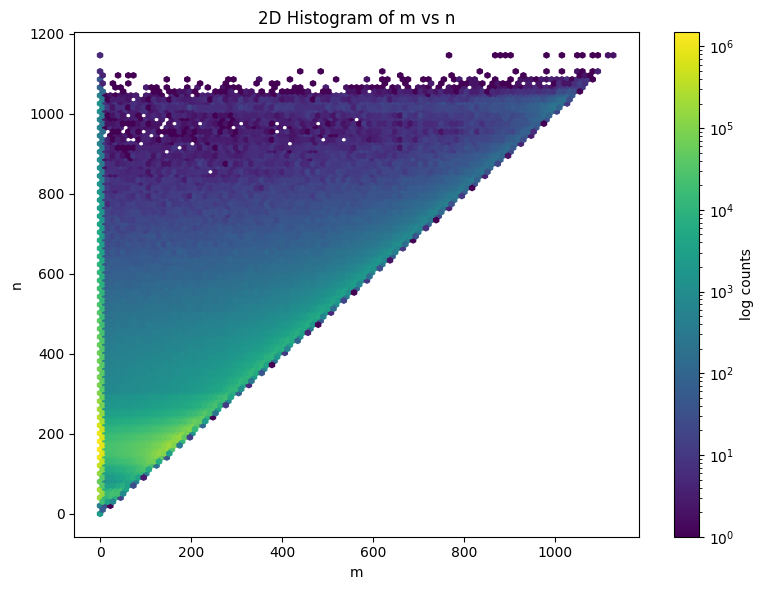

In [18]:
times = 10
ms = []
for i in range(times):
    t = noise_schedule.sample_t(len(lengths))
    noise_rate, total_noise = noise_schedule(t)
    n_drops = torch.poisson(total_noise)
    m = torch.maximum(lengths_tensor - n_drops, torch.tensor([0]))
    ms.append(m)
ms = torch.cat(ms).flatten()

x = ms.detach().cpu().numpy()
y = torch.cat([lengths_tensor] * times).flatten().detach().cpu().numpy()
from matplotlib.colors import LogNorm
plt.figure(figsize=(8,6))
hb = plt.hexbin(x, y, gridsize=100, bins='log', mincnt=1)
plt.colorbar(hb, label='log counts')
plt.xlabel('m')
plt.ylabel('n')
plt.title('2D Histogram of m vs n')
plt.tight_layout()
plt.show()



# VStar Medium

In [6]:
from pcdd.datamodule.star_v2 import StarGraphDataset, SimpleSpaceTokenizer
from pcdd.noise_schedule.idlm import LogLinearNoiseSchedule
import torch


In [7]:

train_data_path = "/work/pi_mccallum_umass_edu/dhruveshpate_umass_edu/diffusion/data/asymmetric_variable_armlength_star_graph_degree=5_min_pathlength=6_max_pathlength=12_vocab_size=56_min_plan_length=5_count=50000/train.csv"
tokenizer = SimpleSpaceTokenizer(vocab_size=56)
dataset = StarGraphDataset(train_data_path, tokenizer)
dataset.load_dataset()

In [8]:
lengths = [(torch.tensor(d["token_type_ids"]) == 2).sum().item() for d in dataset]
lengths_tensor = torch.tensor(lengths)


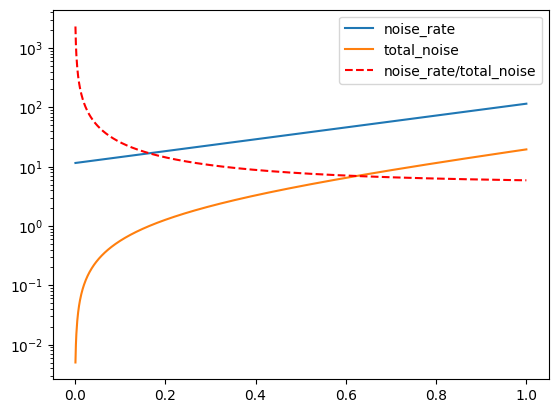

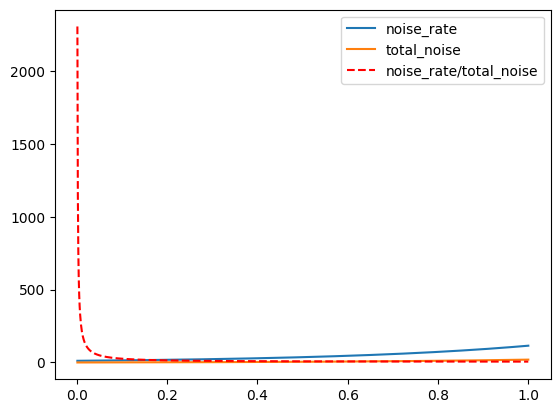

tensor(2305.2063)
tensor(7.7457)
tensor(5.8910)


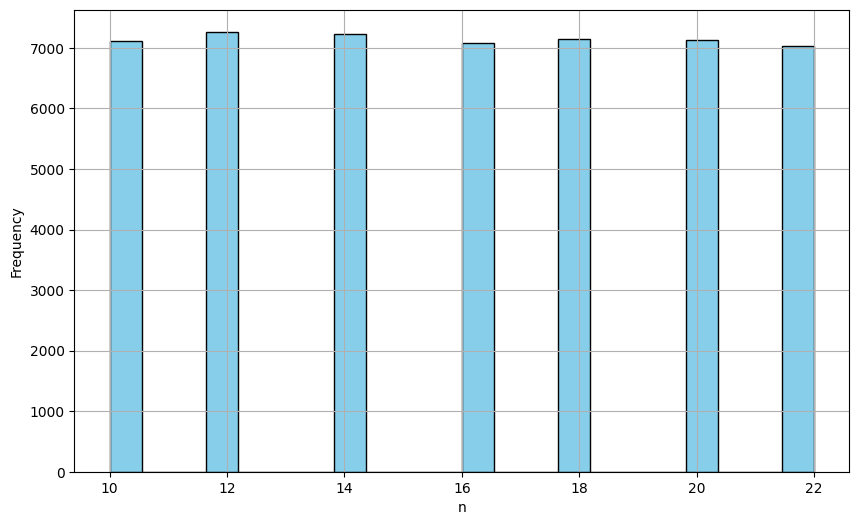

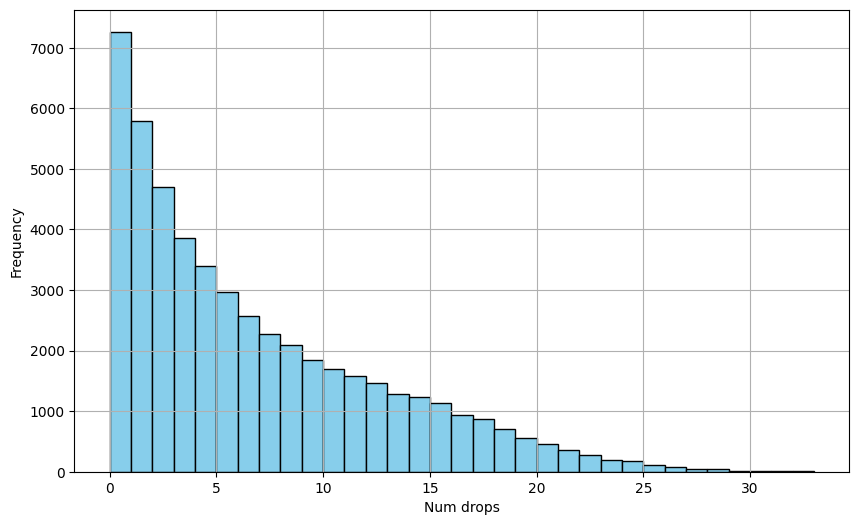

Fraction with zero drops: 0.14532


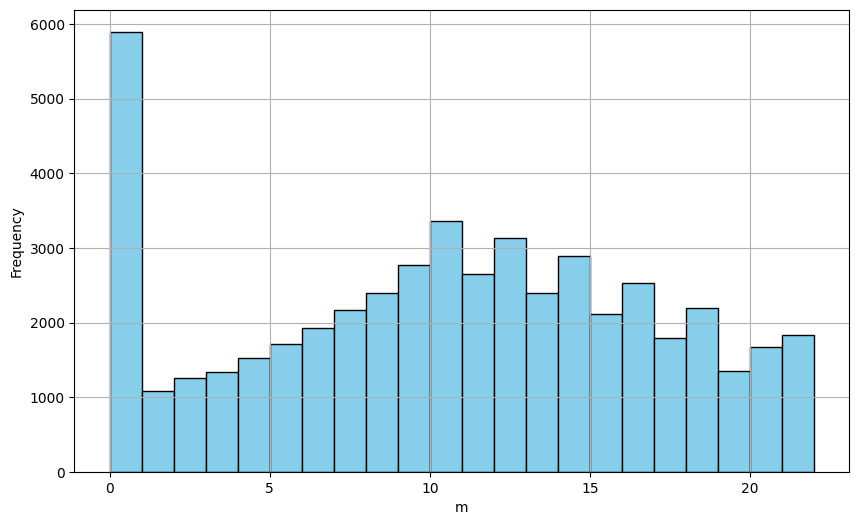

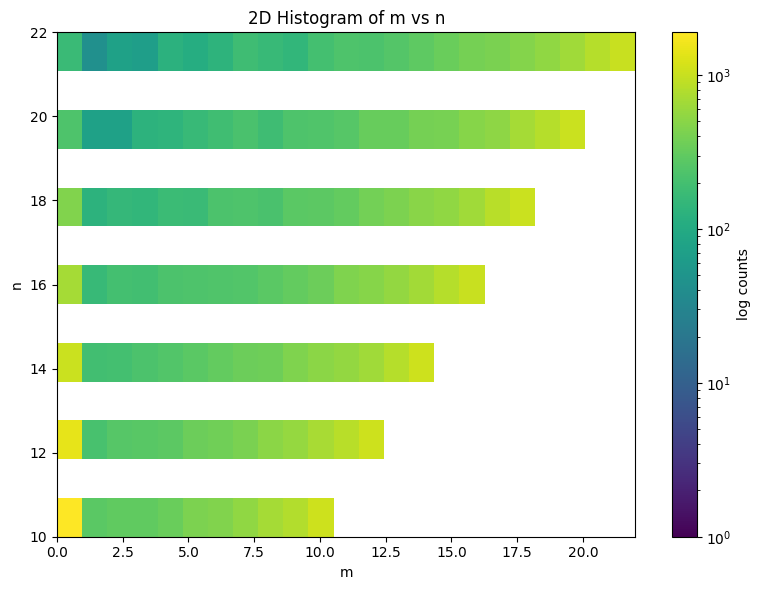

<Figure size 800x600 with 0 Axes>

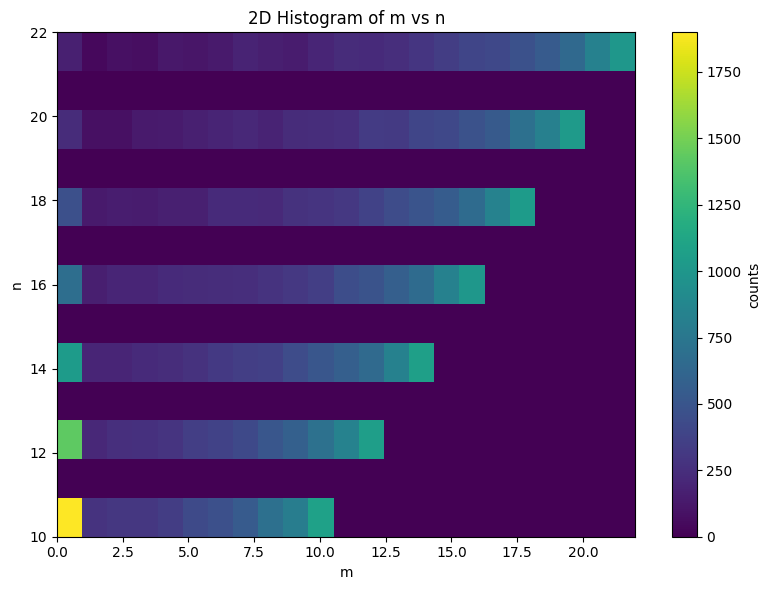

Fraction with m=0: 0.11795999854803085
max wt: 2294.905517578125, total_noise: 0.005028349347412586, n: 22, m: 22.0, S_: 1.0002186298370361
min wt: 0.043732695281505585
min wt: 0.043732695281505585, total_noise: 19.540071487426758, n: 10, m: 0.0, S_: 134.7068634033203


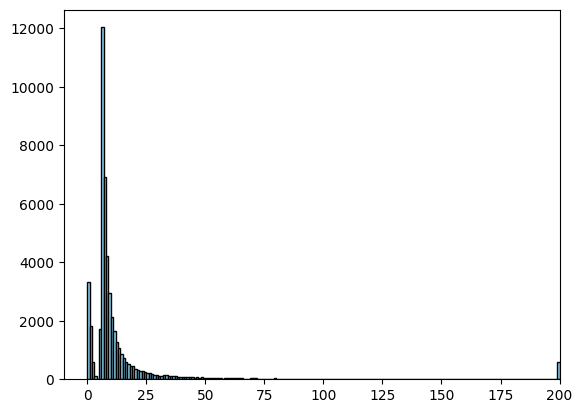

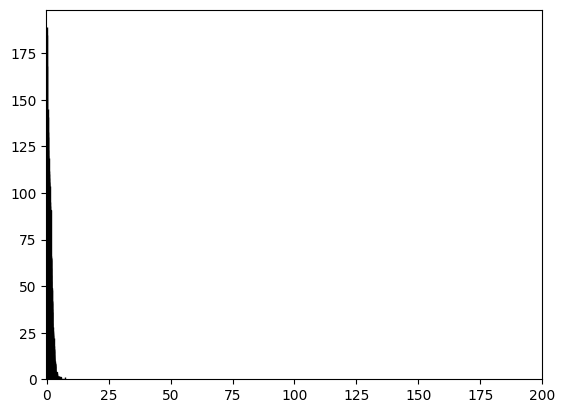

In [9]:
import matplotlib.pyplot as plt
from pcdd.noise_schedule.idlm import LogLinearNoiseSchedule
#noise_schedule = LogLinearNoiseSchedule(sigma_min=10, sigma_max=12)
noise_schedule = LogLinearNoiseSchedule(sigma_min=5, sigma_max=50)

t = torch.linspace(1e-3, 1.0, 1000)
noise_rate, total_noise = noise_schedule(t)

plt.plot(t, noise_rate, label='noise_rate')
plt.plot(t, total_noise, label='total_noise')
ratio = (noise_rate/total_noise)
plt.plot(t, ratio, label='noise_rate/total_noise', color='red', linestyle='--')
plt.yscale('log')
plt.legend()
plt.show()

plt.plot(t, noise_rate, label='noise_rate')
plt.plot(t, total_noise, label='total_noise')
plt.plot(t, (noise_rate/(total_noise )), label='noise_rate/total_noise', color='red', linestyle='--')
plt.legend()
plt.show()
print(ratio[0])
print(ratio[len(ratio)//2])
print(ratio[-1])

t = noise_schedule.sample_t(len(lengths))
noise_rate, total_noise = noise_schedule(t)
ratio = (noise_rate/total_noise)
n_drops = torch.poisson(total_noise)
m = torch.maximum(lengths_tensor - n_drops, torch.tensor([0]))



plt.figure(figsize=(10, 6))
plt.hist(lengths_tensor.numpy(), bins=22, color="skyblue", edgecolor="black")
plt.xlabel("n")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(n_drops.numpy(), bins=int(n_drops.max().item()), color="skyblue", edgecolor="black")
plt.xlabel("Num drops")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

print(f"Fraction with zero drops: {torch.sum(n_drops == 0).item()/len(n_drops)}")

plt.figure(figsize=(10, 6))
plt.hist(m.numpy(), bins=22, color="skyblue", edgecolor="black")
plt.xlabel("m")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


y = lengths_tensor.detach().cpu().numpy()
x = m.detach().cpu().numpy()

# 3a. Using hist2d
from matplotlib.colors import LogNorm
plt.figure(figsize=(8,6))
hb = plt.hist2d(x, y, bins=[int(max(x)-min(x)+1), int(max(y)-min(y)+1)], norm=LogNorm(vmin=1))
plt.colorbar(hb[3], label='log counts')
plt.xlabel('m')
plt.ylabel('n')
plt.title('2D Histogram of m vs n')
plt.tight_layout()
plt.show()


# 3a. Using hist2d
from matplotlib.colors import LogNorm
plt.figure(figsize=(8,6))
plt.figure(figsize=(8,6))
hb = plt.hist2d(x, y, bins=[int(max(x)-min(x)+1), int(max(y)-min(y)+1)])
plt.colorbar(hb[3], label='counts')
plt.xlabel('m')
plt.ylabel('n')
plt.title('2D Histogram of m vs n')
plt.tight_layout()
plt.show()


S_ = hyp1f1_1_nplus1_vec(total_noise, lengths_tensor, K=20)
mask = m == 0
print(f"Fraction with m=0: {mask.sum()/len(mask)}")
S = torch.where(mask, S_, 1.0)
wt = ratio / S
max_wt, max_wt_idx = wt.max(), wt.argmax()
print(
    f"max wt: {max_wt}, total_noise: {total_noise[max_wt_idx]}, n: {lengths_tensor[max_wt_idx]}, m: {m[max_wt_idx]}, S_: {S_[max_wt_idx]}"
)
min_wt, min_wt_idx = wt.min(), wt.argmin()
print(f"min wt: {min_wt}")
print(f"min wt: {min_wt}, total_noise: {total_noise[min_wt_idx]}, n: {lengths_tensor[min_wt_idx]}, m: {m[min_wt_idx]}, S_: {S_[min_wt_idx]}")
max_value = 200  # Define the max value for the x-axis
wt_clipped = torch.clamp(wt, max=max_value)  # Clip the values at max_value
plt.hist(
    wt_clipped.numpy(), bins=max_value, color="skyblue", edgecolor="black"
)
plt.xlim(right=max_value)  # Set the x-axis limit to max_value
plt.show()

# plot wt only for m=0
plt.hist(wt[mask].numpy(), bins=max_value, color="skyblue", edgecolor="black")
plt.xlim(right=max_value)  # Set the x-axis limit to max_value
plt.show()

In [28]:
max(lengths_tensor)

tensor(22)

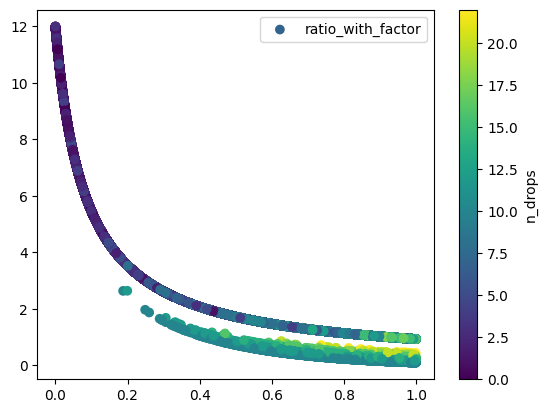

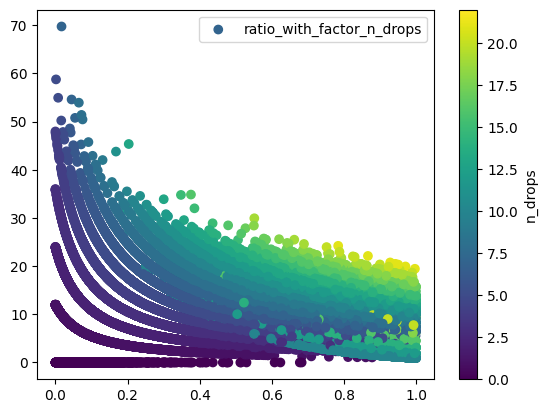

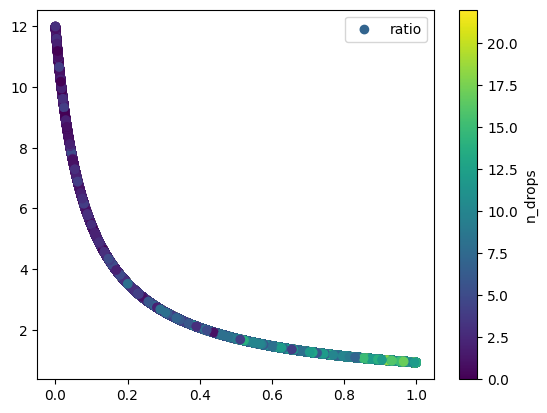

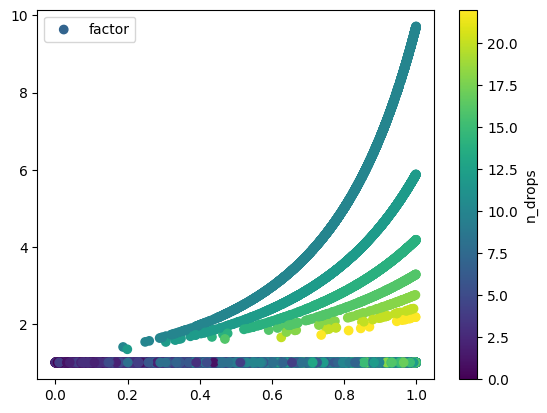

In [32]:
# simulate weights
from pcdd.diffusion.idlm_v2 import incomplete_gamma_factor
import matplotlib.pyplot as plt
from pcdd.noise_schedule.idlm import PoissonNoiseSchedule

noise_schedule = PoissonNoiseSchedule(c=1, sigma=12)

num_examples = len(lengths_tensor)
t = torch.rand(num_examples)
noise_rate, total_noise = noise_schedule(t)
n_drops = torch.poisson(total_noise)
n_drops = torch.minimum(n_drops, lengths_tensor)
final_length = lengths_tensor - n_drops
ratio = noise_rate / total_noise
factor = torch.where(
    final_length > 0,
    1,
    incomplete_gamma_factor(n_drops, total_noise),
)
ratio_with_factor = ratio / factor
ratio_with_factor_n_drops = ratio_with_factor * n_drops
# plot ratio_with_factor vs t with hue using n_drops
plt.scatter(t, ratio_with_factor, c=n_drops, cmap='viridis', label='ratio_with_factor')
plt.colorbar(label='n_drops')
plt.legend()
plt.show()

plt.scatter(t, ratio_with_factor_n_drops, c=n_drops, cmap='viridis', label='ratio_with_factor_n_drops')
plt.colorbar(label='n_drops')
plt.legend()
plt.show()

plt.scatter(t, ratio, c=n_drops, cmap='viridis', label='ratio')
plt.colorbar(label='n_drops')
plt.legend()
plt.show()

plt.scatter(t, factor, c=n_drops, cmap='viridis', label='factor')
plt.colorbar(label='n_drops')
plt.legend()
plt.show()


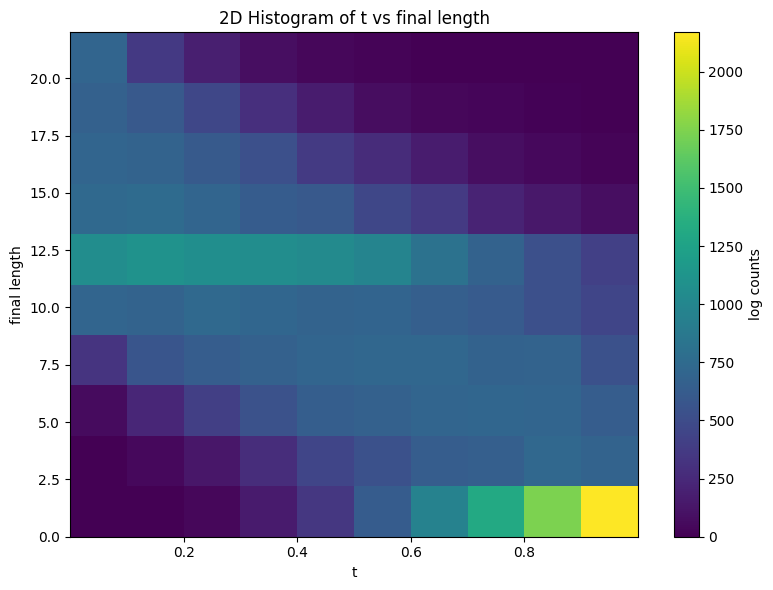

In [30]:

# 3a. Using hist2d
from matplotlib.colors import LogNorm
plt.figure(figsize=(8,6))
hb = plt.hist2d(t, final_length)
plt.colorbar(hb[3], label='log counts')
plt.xlabel('t')
plt.ylabel('final length')
plt.title('2D Histogram of t vs final length')
plt.tight_layout()
plt.show()

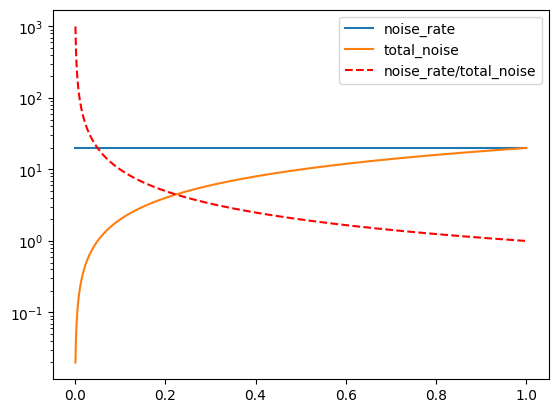

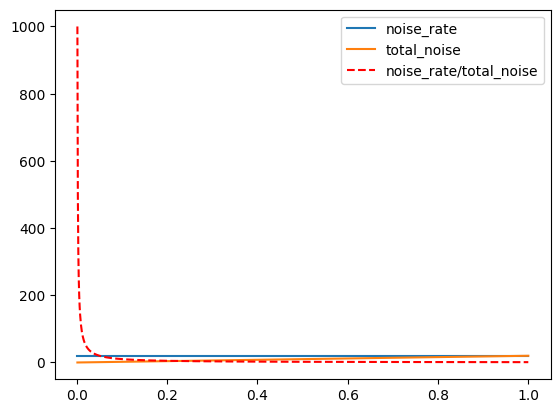

tensor(999.9999)
tensor(1.9960)
tensor(1.)


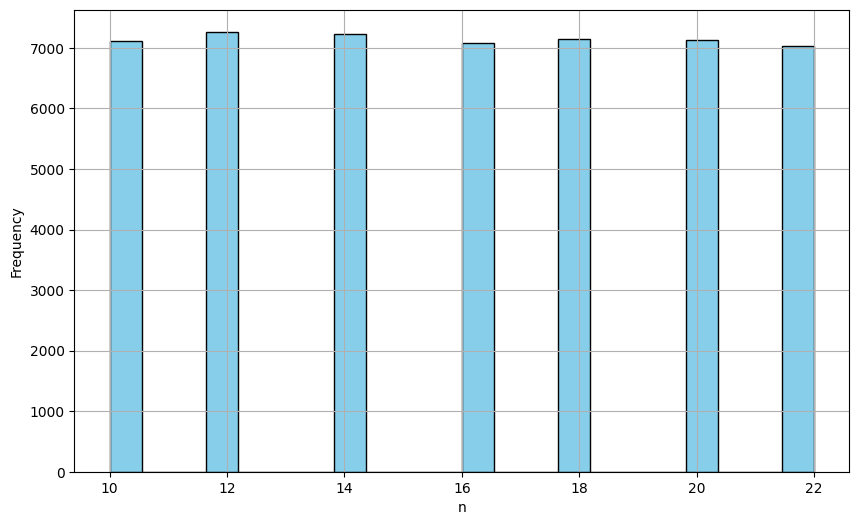

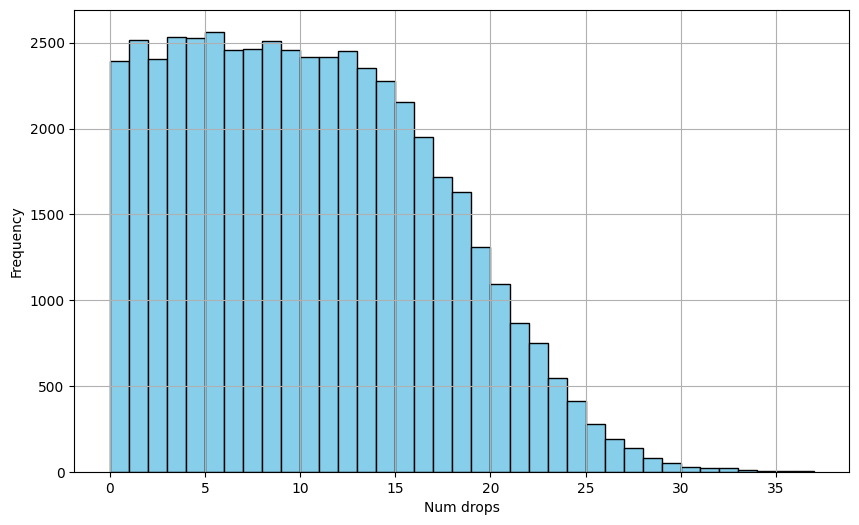

Fraction with zero drops: 0.04782


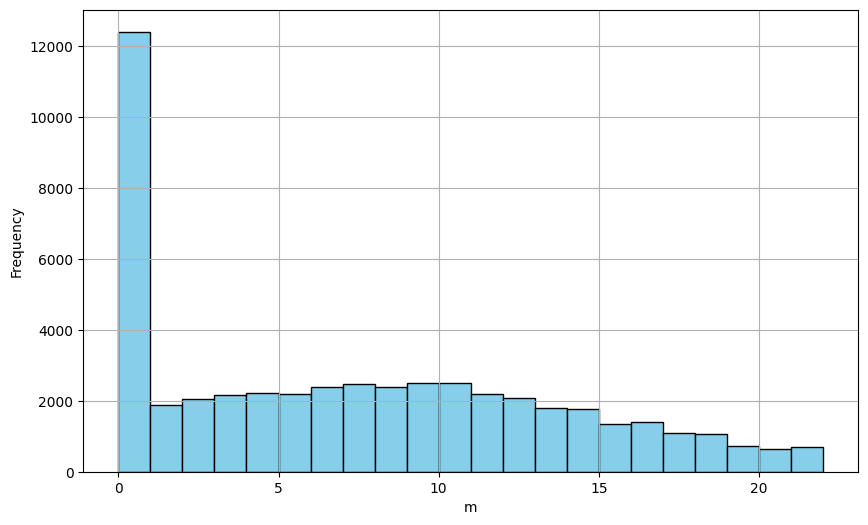

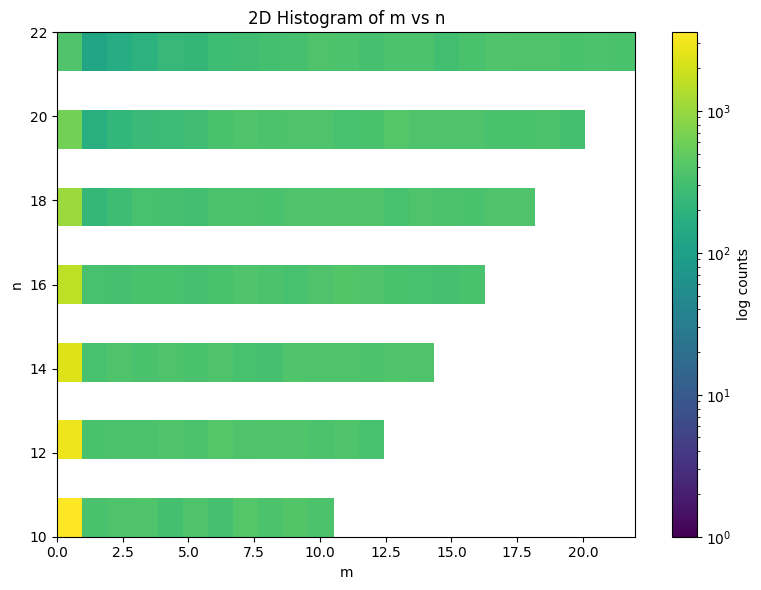

<Figure size 800x600 with 0 Axes>

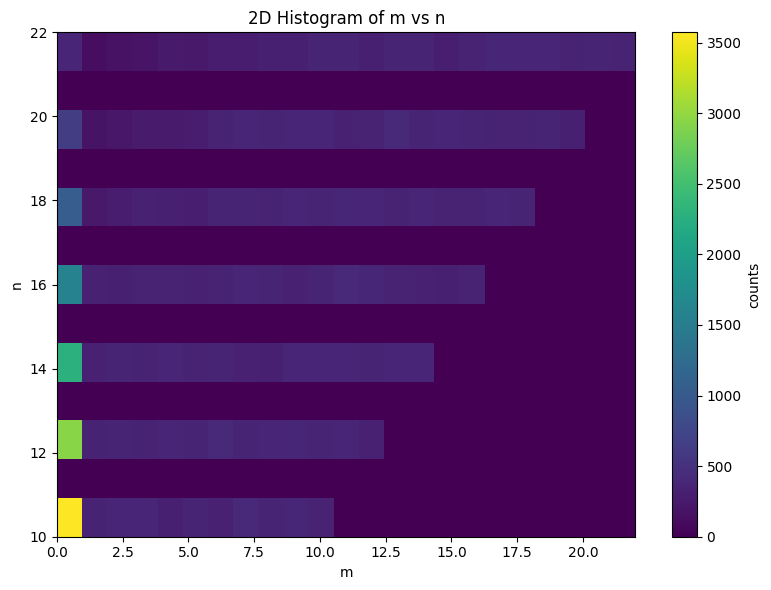

In [10]:
import matplotlib.pyplot as plt
from pcdd.noise_schedule.idlm import PoissonNoiseSchedule
#noise_schedule = LogLinearNoiseSchedule(sigma_min=10, sigma_max=12)
noise_schedule = PoissonNoiseSchedule(c=0, sigma=20)

t = torch.linspace(1e-3, 1.0, 1000)
noise_rate, total_noise = noise_schedule(t)

plt.plot(t, noise_rate, label='noise_rate')
plt.plot(t, total_noise, label='total_noise')
ratio = (noise_rate/total_noise)
plt.plot(t, ratio, label='noise_rate/total_noise', color='red', linestyle='--')
plt.yscale('log')
plt.legend()
plt.show()

plt.plot(t, noise_rate, label='noise_rate')
plt.plot(t, total_noise, label='total_noise')
plt.plot(t, (noise_rate/(total_noise )), label='noise_rate/total_noise', color='red', linestyle='--')
plt.legend()
plt.show()
print(ratio[0])
print(ratio[len(ratio)//2])
print(ratio[-1])

t = noise_schedule.sample_t(len(lengths))
noise_rate, total_noise = noise_schedule(t)
n_drops = torch.poisson(total_noise)
m = torch.maximum(lengths_tensor - n_drops, torch.tensor([0]))



plt.figure(figsize=(10, 6))
plt.hist(lengths_tensor.numpy(), bins=22, color="skyblue", edgecolor="black")
plt.xlabel("n")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(n_drops.numpy(), bins=int(n_drops.max().item()), color="skyblue", edgecolor="black")
plt.xlabel("Num drops")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

print(f"Fraction with zero drops: {torch.sum(n_drops == 0).item()/len(n_drops)}")

plt.figure(figsize=(10, 6))
plt.hist(m.numpy(), bins=22, color="skyblue", edgecolor="black")
plt.xlabel("m")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


y = lengths_tensor.detach().cpu().numpy()
x = m.detach().cpu().numpy()

# 3a. Using hist2d
from matplotlib.colors import LogNorm
plt.figure(figsize=(8,6))
hb = plt.hist2d(x, y, bins=[int(max(x)-min(x)+1), int(max(y)-min(y)+1)], norm=LogNorm(vmin=1))
plt.colorbar(hb[3], label='log counts')
plt.xlabel('m')
plt.ylabel('n')
plt.title('2D Histogram of m vs n')
plt.tight_layout()
plt.show()


# 3a. Using hist2d
from matplotlib.colors import LogNorm
plt.figure(figsize=(8,6))
plt.figure(figsize=(8,6))
hb = plt.hist2d(x, y, bins=[int(max(x)-min(x)+1), int(max(y)-min(y)+1)])
plt.colorbar(hb[3], label='counts')
plt.xlabel('m')
plt.ylabel('n')
plt.title('2D Histogram of m vs n')
plt.tight_layout()
plt.show()

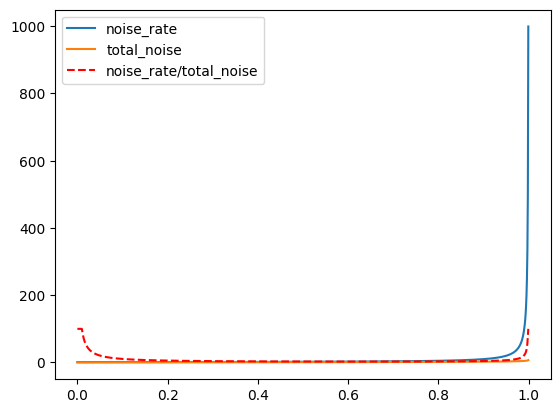

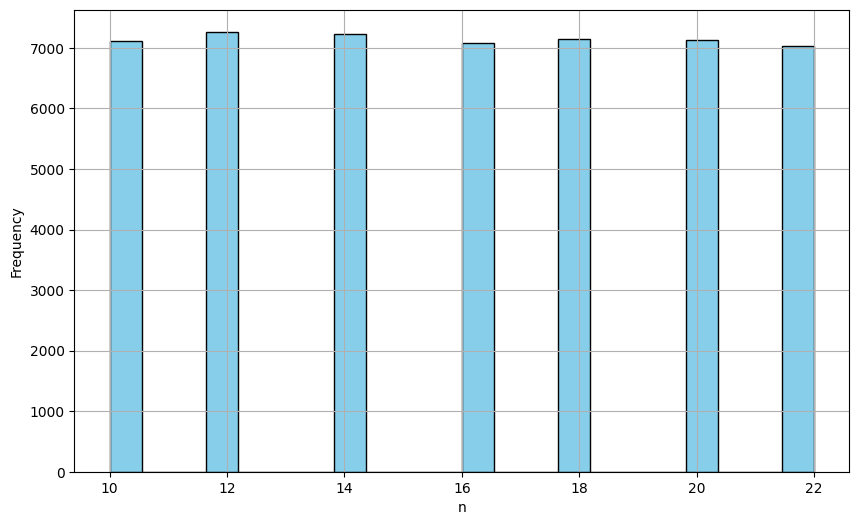

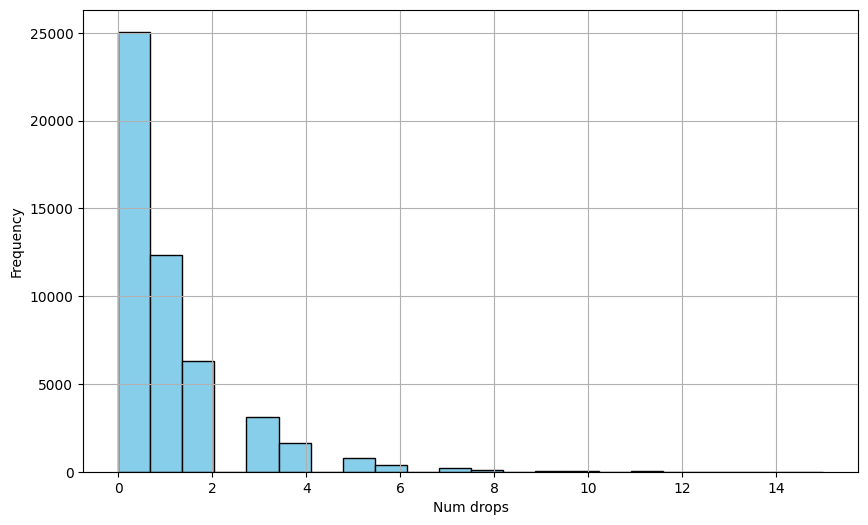

Fraction with zero drops: 0.50142


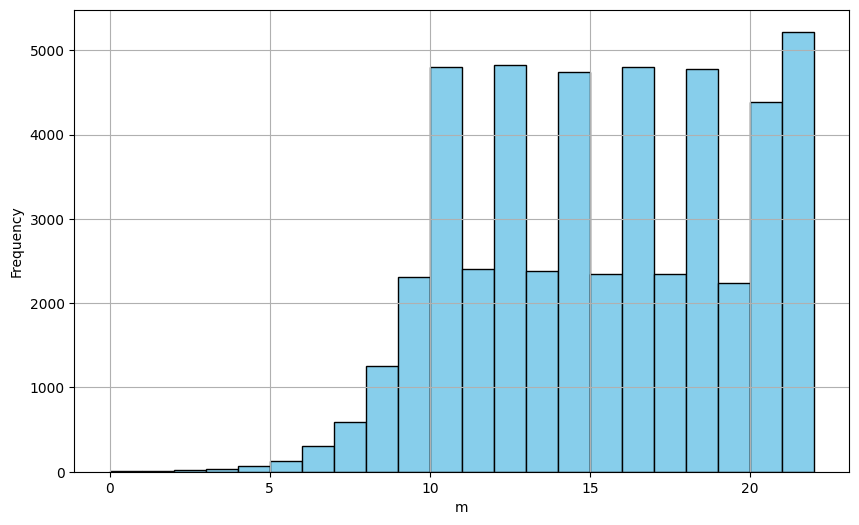

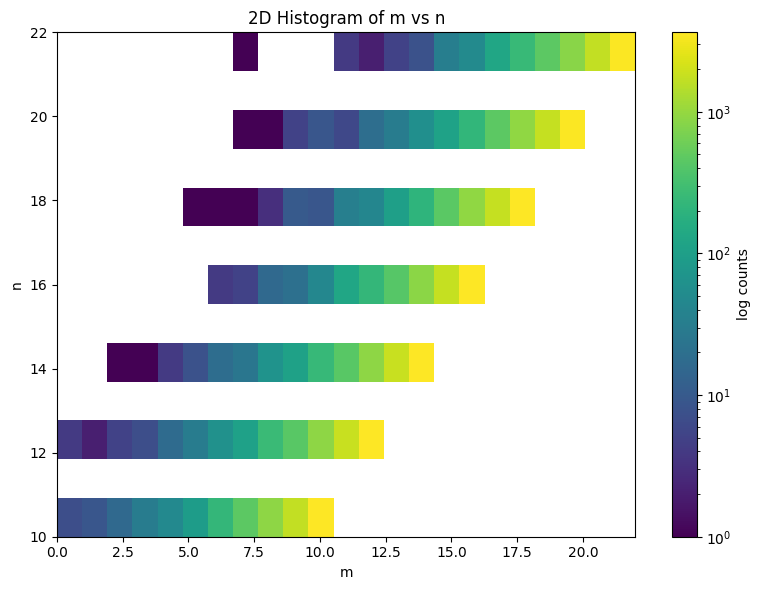

<Figure size 800x600 with 0 Axes>

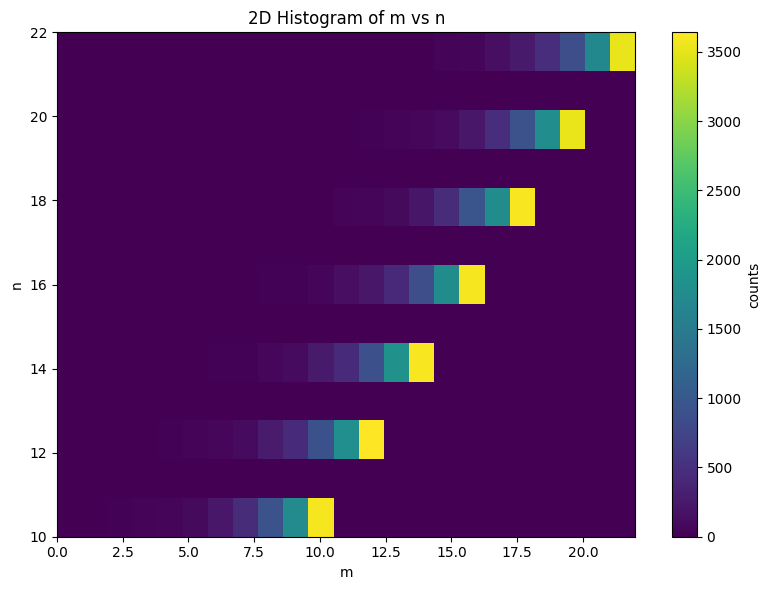

In [56]:
import matplotlib.pyplot as plt
from pcdd.noise_schedule.mdlm import ContinuousTimeLogLinearSchedule
noise_schedule = ContinuousTimeLogLinearSchedule(sigma_min=0, sigma_max=100)

t = torch.linspace(1e-4, 1.0, 1000)
noise_rate, total_noise = noise_schedule(t)
plt.plot(t, noise_rate, label='noise_rate')
plt.plot(t, total_noise, label='total_noise')
plt.plot(t, (noise_rate/(total_noise)).clamp(max=100), label='noise_rate/total_noise', color='red', linestyle='--')
plt.legend()
plt.show()
#print(noise_rate/total_noise)
#print((noise_rate/total_noise)[0])

t = noise_schedule.sample_t(len(lengths))
noise_rate, total_noise = noise_schedule(t)
n_drops = torch.poisson(total_noise)
m = torch.maximum(lengths_tensor - n_drops, torch.tensor([0]))



plt.figure(figsize=(10, 6))
plt.hist(lengths_tensor.numpy(), bins=22, color="skyblue", edgecolor="black")
plt.xlabel("n")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(n_drops.numpy(), bins=22, color="skyblue", edgecolor="black")
plt.xlabel("Num drops")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

print(f"Fraction with zero drops: {torch.sum(n_drops == 0).item()/len(n_drops)}")

plt.figure(figsize=(10, 6))
plt.hist(m.numpy(), bins=22, color="skyblue", edgecolor="black")
plt.xlabel("m")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


y = lengths_tensor.detach().cpu().numpy()
x = m.detach().cpu().numpy()

# 3a. Using hist2d
from matplotlib.colors import LogNorm
plt.figure(figsize=(8,6))
hb = plt.hist2d(x, y, bins=[int(max(x)-min(x)+1), int(max(y)-min(y)+1)], norm=LogNorm(vmin=1))
plt.colorbar(hb[3], label='log counts')
plt.xlabel('m')
plt.ylabel('n')
plt.title('2D Histogram of m vs n')
plt.tight_layout()
plt.show()


# 3a. Using hist2d
from matplotlib.colors import LogNorm
plt.figure(figsize=(8,6))
plt.figure(figsize=(8,6))
hb = plt.hist2d(x, y, bins=[int(max(x)-min(x)+1), int(max(y)-min(y)+1)])
plt.colorbar(hb[3], label='counts')
plt.xlabel('m')
plt.ylabel('n')
plt.title('2D Histogram of m vs n')
plt.tight_layout()
plt.show()

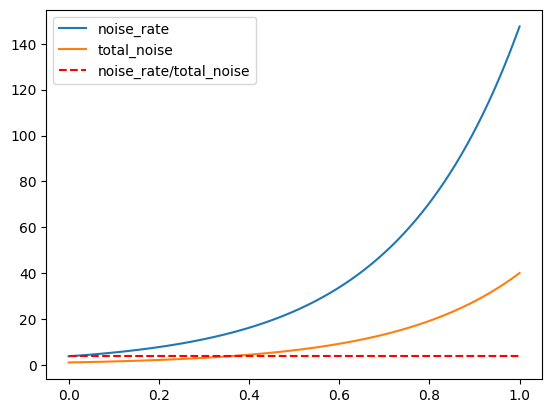

tensor(3.6889)


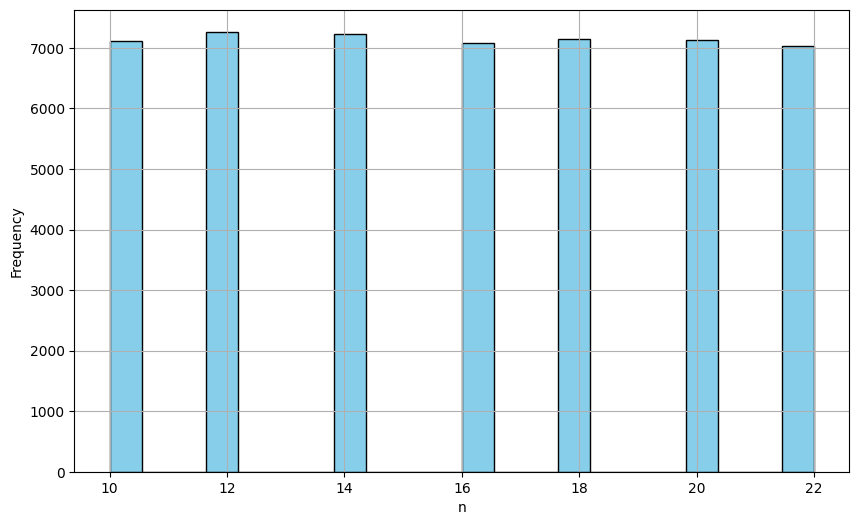

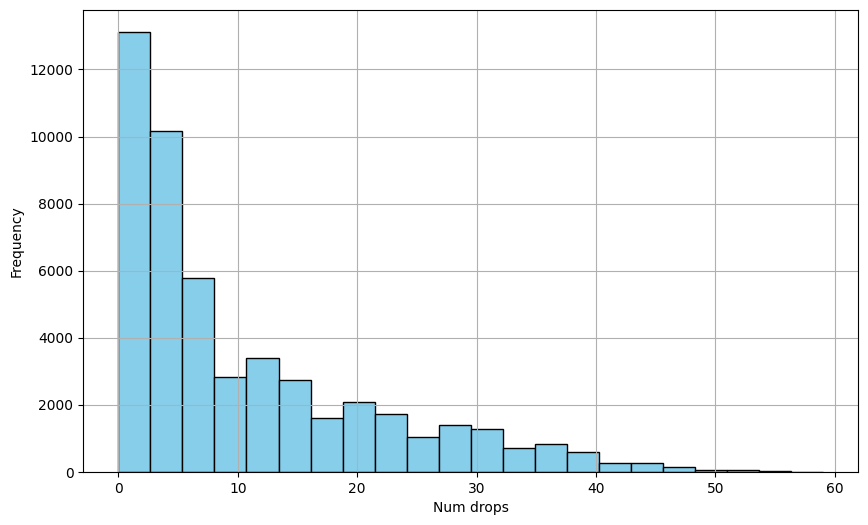

Fraction with zero drops: 0.05896


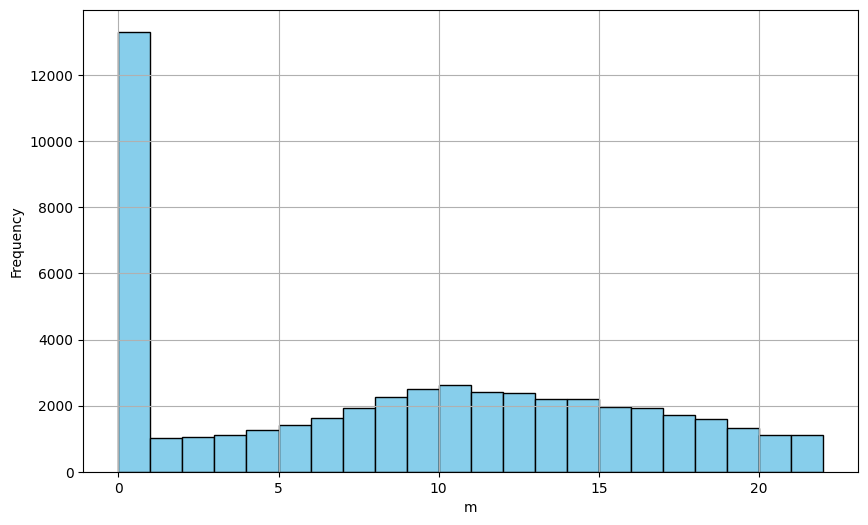

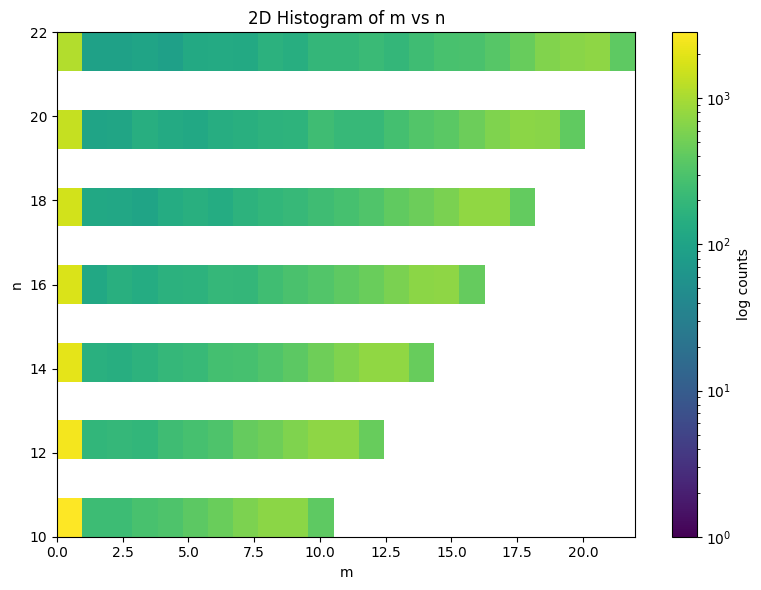

<Figure size 800x600 with 0 Axes>

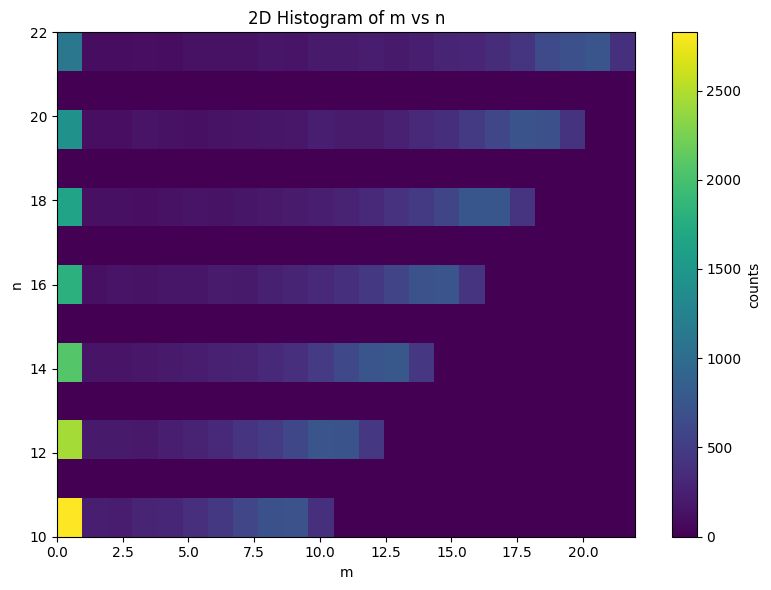

In [11]:
import matplotlib.pyplot as plt
from pcdd.noise_schedule.idlm import GeometricNoiseSchedule
noise_schedule = GeometricNoiseSchedule(sigma_min=1, sigma_max=40, antithetic_sampling=False)

t = torch.linspace(1e-4, 1.0, 1000)
noise_rate, total_noise = noise_schedule(t)
plt.plot(t, noise_rate, label='noise_rate')
plt.plot(t, total_noise, label='total_noise')
plt.plot(t, (noise_rate/(total_noise)), label='noise_rate/total_noise', color='red', linestyle='--')
plt.legend()
plt.show()
#print(noise_rate/total_noise)
print((noise_rate/total_noise)[0])

t = noise_schedule.sample_t(len(lengths))
noise_rate, total_noise = noise_schedule(t)
n_drops = torch.poisson(total_noise)
m = torch.maximum(lengths_tensor - n_drops, torch.tensor([0]))



plt.figure(figsize=(10, 6))
plt.hist(lengths_tensor.numpy(), bins=22, color="skyblue", edgecolor="black")
plt.xlabel("n")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(n_drops.numpy(), bins=22, color="skyblue", edgecolor="black")
plt.xlabel("Num drops")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

print(f"Fraction with zero drops: {torch.sum(n_drops == 0).item()/len(n_drops)}")

plt.figure(figsize=(10, 6))
plt.hist(m.numpy(), bins=22, color="skyblue", edgecolor="black")
plt.xlabel("m")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


y = lengths_tensor.detach().cpu().numpy()
x = m.detach().cpu().numpy()

# 3a. Using hist2d
from matplotlib.colors import LogNorm
plt.figure(figsize=(8,6))
hb = plt.hist2d(x, y, bins=[int(max(x)-min(x)+1), int(max(y)-min(y)+1)], norm=LogNorm(vmin=1))
plt.colorbar(hb[3], label='log counts')
plt.xlabel('m')
plt.ylabel('n')
plt.title('2D Histogram of m vs n')
plt.tight_layout()
plt.show()


# 3a. Using hist2d
from matplotlib.colors import LogNorm
plt.figure(figsize=(8,6))
plt.figure(figsize=(8,6))
hb = plt.hist2d(x, y, bins=[int(max(x)-min(x)+1), int(max(y)-min(y)+1)])
plt.colorbar(hb[3], label='counts')
plt.xlabel('m')
plt.ylabel('n')
plt.title('2D Histogram of m vs n')
plt.tight_layout()
plt.show()

In [1]:
import datasets
tokenized = datasets.load_from_disk('/work/pi_mccallum_umass_edu/dhruveshpate_umass_edu/diffusion/data/lm1b/train')


Loading dataset from disk:   0%|          | 0/256 [00:00<?, ?it/s]

In [2]:
def length(example):
    example["length"] = len(example["token_ids"])
    return example
lengths = tokenized.map(length, batched=False, num_proc=8)

Map (num_proc=8):   0%|          | 0/30301028 [00:00<?, ? examples/s]

TimeoutError: 

In [8]:
import pandas as pd
import torch
#filename = f"../logs/length_analysis/length_summaries_{sigma:.2f}.csv"
filename = f"../logs/length_analysis/length_summaries_10.00.csv"
summaries = pd.read_csv(filename)
summaries.describe()

Unnamed: 0     n_minus_m             n             m             t  \
count  1.280000e+07  1.280000e+07  1.280000e+07  1.280000e+07  1.280000e+07   
mean   6.400000e+06  4.961388e+00  3.043961e+01  2.547822e+01  4.998807e-01   
std    3.695042e+06  3.601908e+00  1.474503e+01  1.512521e+01  2.886622e-01   
min    0.000000e+00  0.000000e+00  3.000000e+00  1.000000e+00  0.000000e+00   
25%    3.200000e+06  2.000000e+00  2.000000e+01  1.500000e+01  2.499250e-01   
50%    6.400000e+06  5.000000e+00  2.800000e+01  2.400000e+01  4.999278e-01   
75%    9.599999e+06  7.000000e+00  3.800000e+01  3.400000e+01  7.497933e-01   
max    1.280000e+07  2.800000e+01  1.280000e+02  1.280000e+02  9.999999e-01   

              noise  
count  1.280000e+07  
mean   4.998807e+00  
std    2.886622e+00  
min    0.000000e+00  
25%    2.499249e+00  
50%    4.999278e+00  
75%    7.497933e+00  
max    9.999999e+00

In [9]:
lengths_tensor = torch.tensor(list(summaries["n"]))

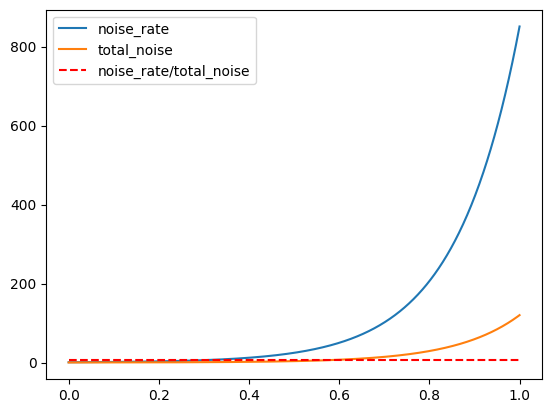

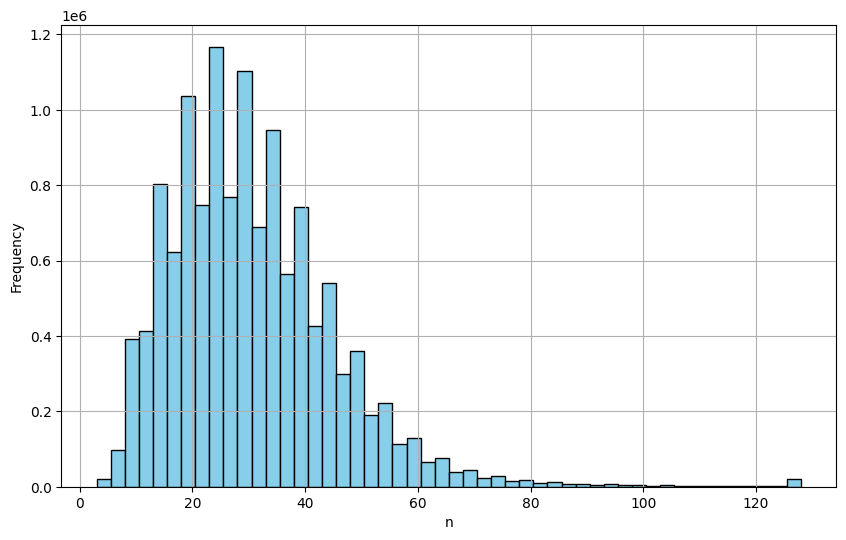

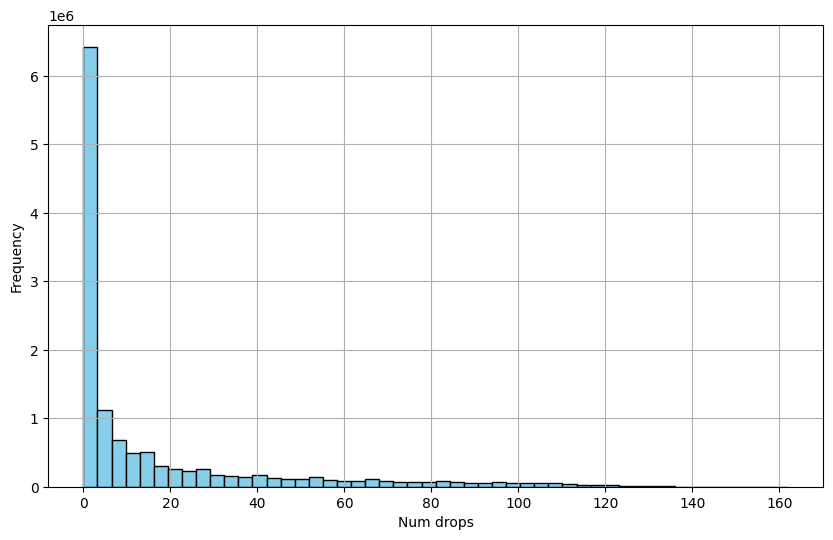

Fraction with zero drops: 0.257006484375


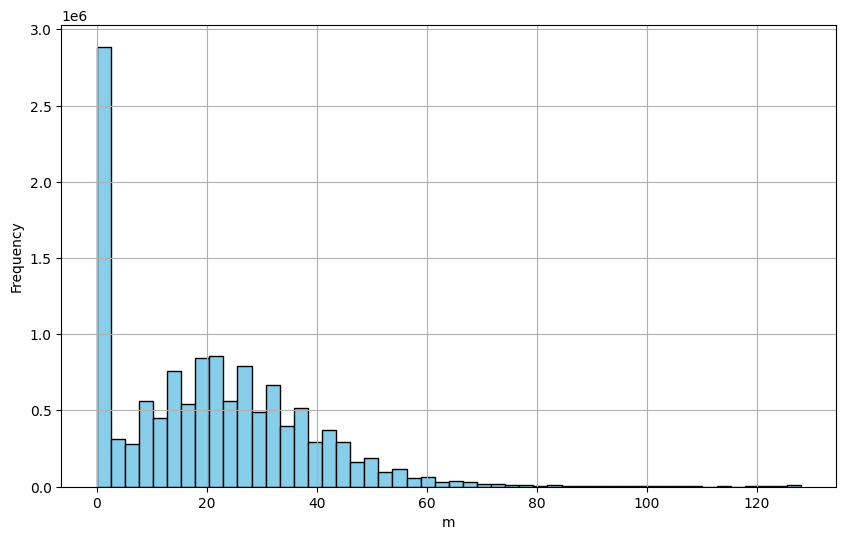

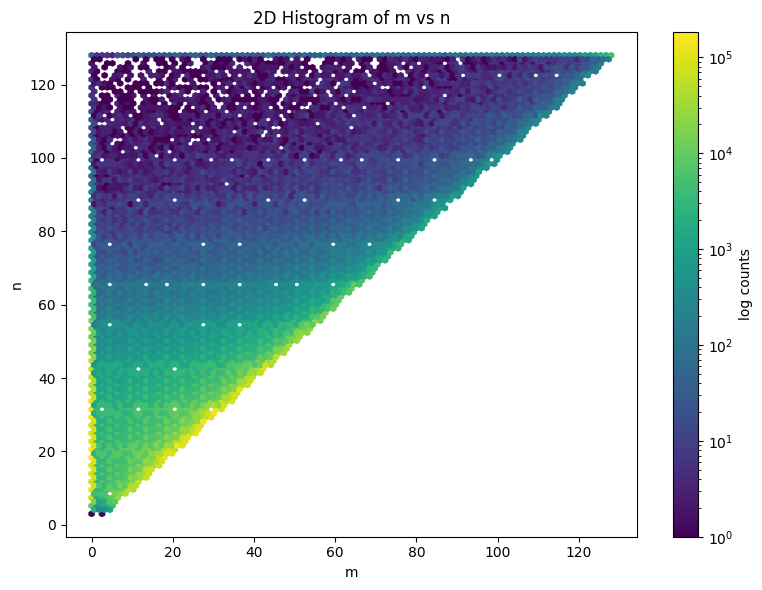

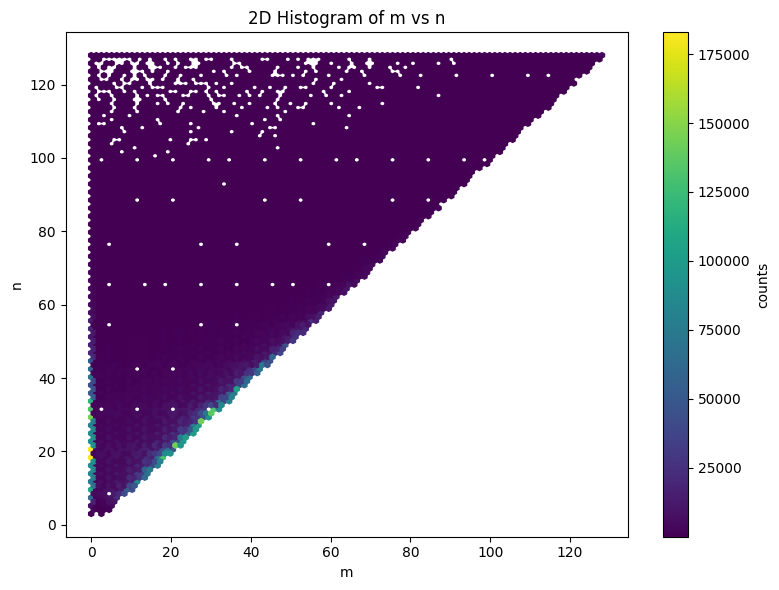

In [17]:
import matplotlib.pyplot as plt
from pcdd.noise_schedule.idlm import LogLinearNoiseSchedule, GeometricNoiseSchedule
import torch
#noise_schedule = LogLinearNoiseSchedule(sigma_min=10, sigma_max=500)
noise_schedule = GeometricNoiseSchedule(sigma_min=0.1, sigma_max=120)

t = torch.linspace(0.0, 1.0, 1000)
noise_rate, total_noise = noise_schedule(t)
plt.plot(t, noise_rate, label='noise_rate')
plt.plot(t, total_noise, label='total_noise')
plt.plot(t, noise_rate/total_noise, label='noise_rate/total_noise', color='red', linestyle='--')
plt.legend()
plt.show()


t = noise_schedule.sample_t(len(lengths_tensor))
noise_rate, total_noise = noise_schedule(t)
n_drops = torch.poisson(total_noise)
m = torch.maximum(lengths_tensor - n_drops, torch.tensor([0]))



plt.figure(figsize=(10, 6))
plt.hist(lengths_tensor.numpy(), bins=50, color="skyblue", edgecolor="black")
plt.xlabel("n")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(n_drops.numpy(), bins=50, color="skyblue", edgecolor="black")
plt.xlabel("Num drops")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

print(f"Fraction with zero drops: {torch.sum(n_drops == 0).item()/len(n_drops)}")

plt.figure(figsize=(10, 6))
plt.hist(m.numpy(), bins=50, color="skyblue", edgecolor="black")
plt.xlabel("m")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


y = lengths_tensor.detach().cpu().numpy()
x = m.detach().cpu().numpy()

# 3a. Using hist2d
from matplotlib.colors import LogNorm
plt.figure(figsize=(8,6))
#hb = plt.hist2d(x, y, bins=100, norm=LogNorm(vmin=1))    # you can tweak bins
#plt.colorbar(hb[3], label='counts')
hb = plt.hexbin(x, y, gridsize=100, bins='log', mincnt=1)
plt.colorbar(hb, label='log counts')
plt.xlabel('m')
plt.ylabel('n')
plt.title('2D Histogram of m vs n')
plt.tight_layout()
plt.show()


# 3a. Using hist2d
from matplotlib.colors import LogNorm
plt.figure(figsize=(8,6))
#hb = plt.hist2d(x, y, bins=100, norm=LogNorm(vmin=1))    # you can tweak bins
#plt.colorbar(hb[3], label='counts')
hb = plt.hexbin(x, y, gridsize=100, mincnt=1)
plt.colorbar(hb, label='counts')
plt.xlabel('m')
plt.ylabel('n')
plt.title('2D Histogram of m vs n')
plt.tight_layout()
plt.show()

# Zebra

In [5]:
import datasets
import torch
tokenized = datasets.load_from_disk('/work/pi_mccallum_umass_edu/dhruveshpate_umass_edu/diffusion/data/AvinashAmballa/zebra-puzzles-sorted/train')


In [7]:

def length(example):
    example["length"] = (torch.tensor(example["token_type_ids"]) == 2).sum().item()
    return example

lengths = tokenized.map(length, batched=False, num_proc=8)
# randomly subsample 100000

lengths_tensor = torch.tensor(list(lengths["length"]))

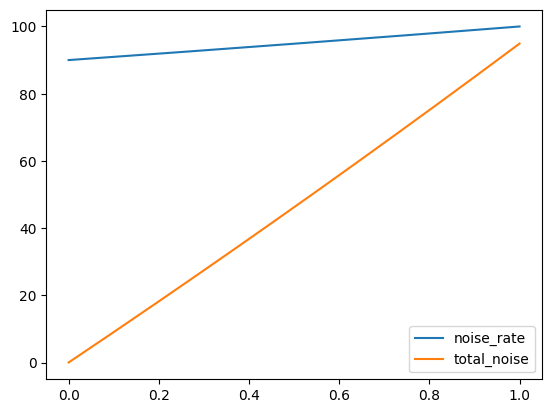

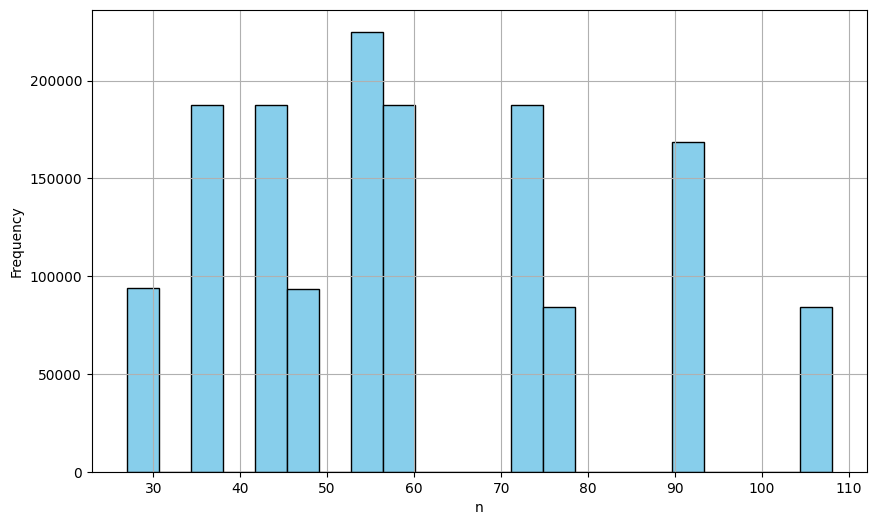

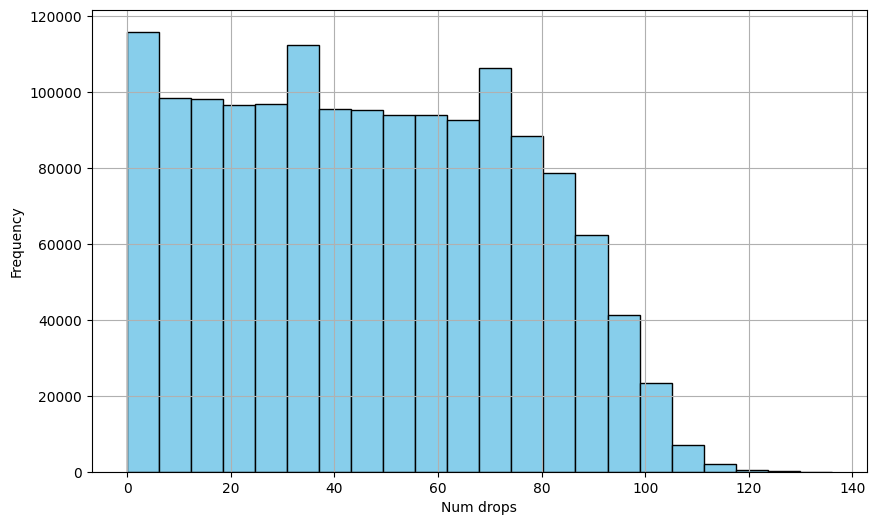

Fraction with zero drops: 0.010966489836546033


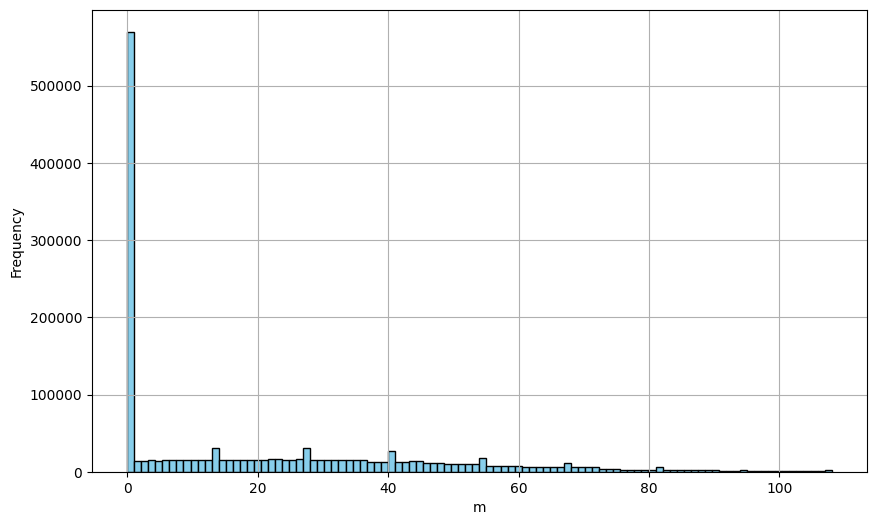

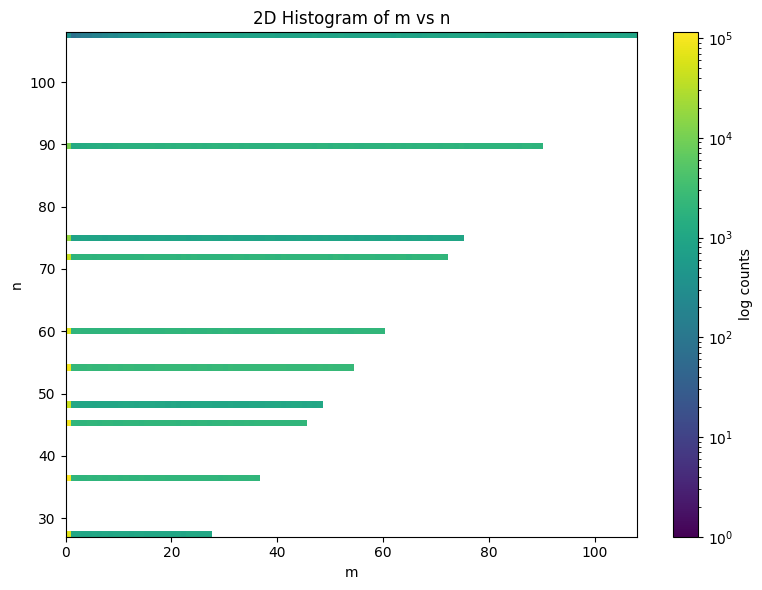

<Figure size 800x600 with 0 Axes>

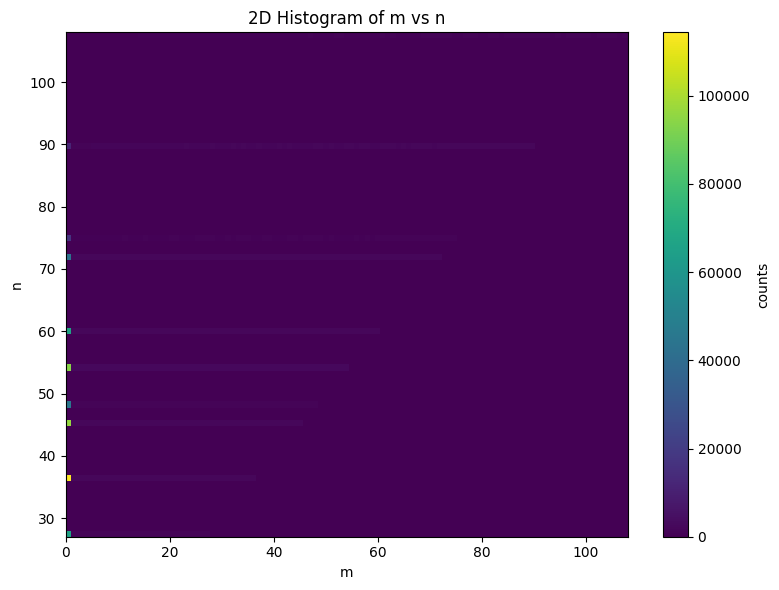

In [9]:
from pcdd.datamodule.star_v2 import StarGraphDataset, SimpleSpaceTokenizer
from pcdd.noise_schedule.idlm import LogLinearNoiseSchedule
import torch
import matplotlib.pyplot as plt
noise_schedule = LogLinearNoiseSchedule(sigma_min=90, sigma_max=100)

t = torch.linspace(1e-4, 1.0, 1000)
noise_rate, total_noise = noise_schedule(t)
plt.plot(t, noise_rate, label='noise_rate')
plt.plot(t, total_noise, label='total_noise')
#plt.plot(t, (noise_rate/(total_noise + 1e-6)), label='noise_rate/total_noise', color='red', linestyle='--')
plt.legend()
plt.show()
#print(noise_rate/total_noise)
#print((noise_rate/total_noise)[0])

t = noise_schedule.sample_t(len(lengths))
noise_rate, total_noise = noise_schedule(t)
n_drops = torch.poisson(total_noise)
m = torch.maximum(lengths_tensor - n_drops, torch.tensor([0]))



plt.figure(figsize=(10, 6))
plt.hist(lengths_tensor.numpy(), bins=22, color="skyblue", edgecolor="black")
plt.xlabel("n")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(n_drops.numpy(), bins=22, color="skyblue", edgecolor="black")
plt.xlabel("Num drops")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

print(f"Fraction with zero drops: {torch.sum(n_drops == 0).item()/len(n_drops)}")

plt.figure(figsize=(10, 6))
plt.hist(m.numpy(), bins=100, color="skyblue", edgecolor="black")
plt.xlabel("m")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


y = lengths_tensor.detach().cpu().numpy()
x = m.detach().cpu().numpy()

# 3a. Using hist2d
from matplotlib.colors import LogNorm
plt.figure(figsize=(8,6))
hb = plt.hist2d(x, y, bins=[int(max(x)-min(x)+1), int(max(y)-min(y)+1)], norm=LogNorm(vmin=1))
plt.colorbar(hb[3], label='log counts')
plt.xlabel('m')
plt.ylabel('n')
plt.title('2D Histogram of m vs n')
plt.tight_layout()
plt.show()


# 3a. Using hist2d
from matplotlib.colors import LogNorm
plt.figure(figsize=(8,6))
plt.figure(figsize=(8,6))
hb = plt.hist2d(x, y, bins=[int(max(x)-min(x)+1), int(max(y)-min(y)+1)])
plt.colorbar(hb[3], label='counts')
plt.xlabel('m')
plt.ylabel('n')
plt.title('2D Histogram of m vs n')
plt.tight_layout()
plt.show()

# CFG

In [14]:
import datasets
import torch
from pcdd.datamodule.grammar import IDLMSpaceTokenizer
ds = datasets.Dataset.from_text('/work/pi_mccallum_umass_edu/dhruveshpate_umass_edu/diffusion/data/9fdde374/train.txt')


def length(example):
    example["length"] = len(example["text"].split(" "))
    return example

lengths = ds.map(length, batched=False, num_proc=8)
lengths_tensor = torch.tensor(lengths["length"])

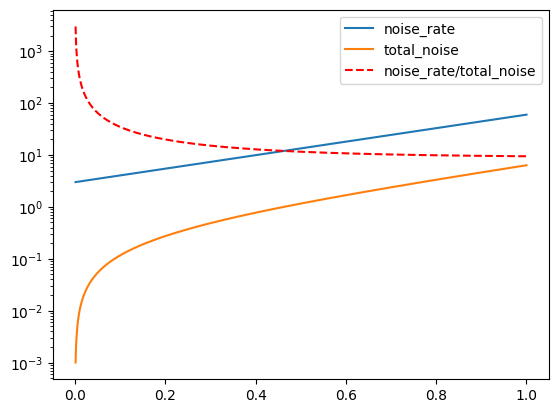

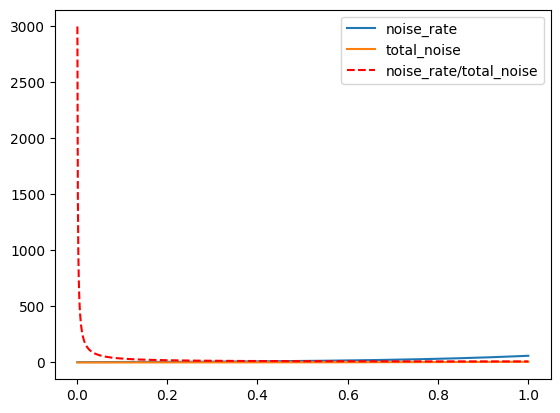

tensor(3000.1865)
tensor(11.5492)
tensor(9.4467)


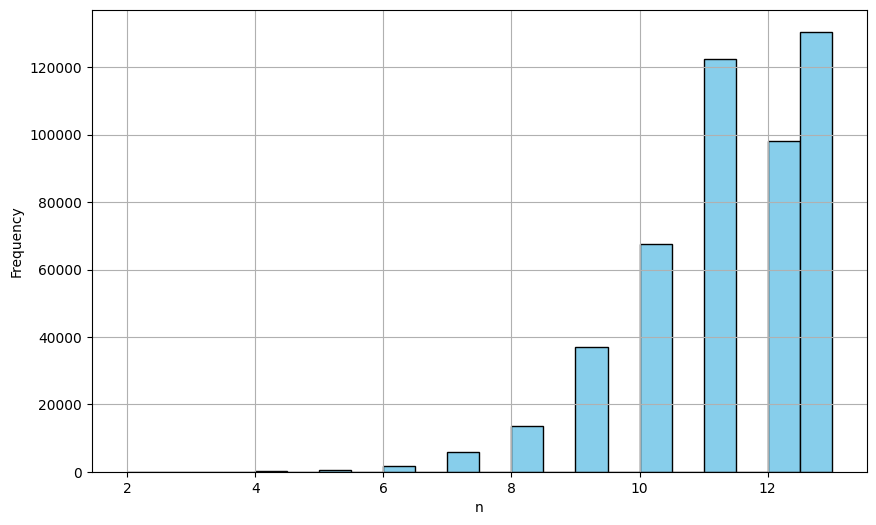

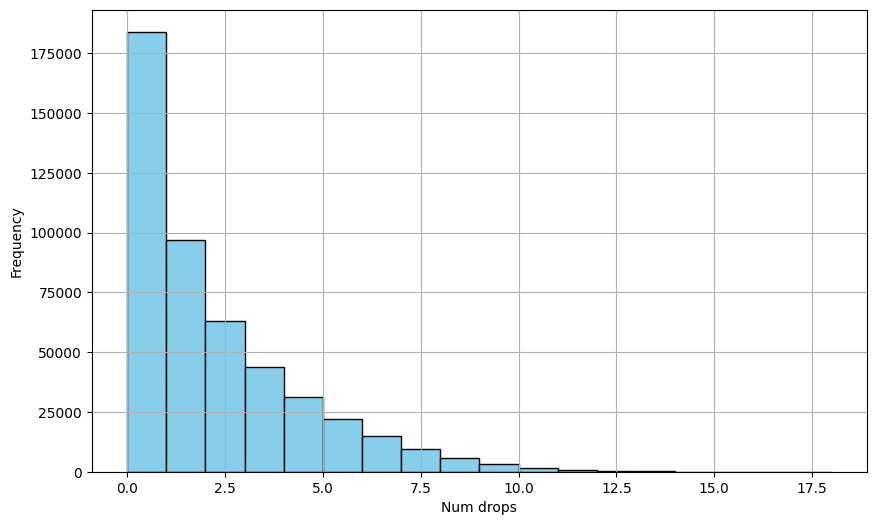

Fraction with zero drops: 0.38547716538731397


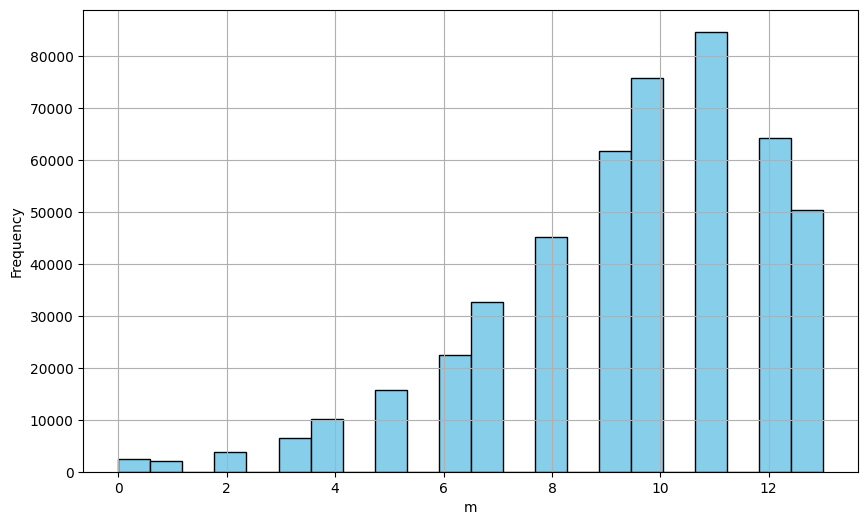

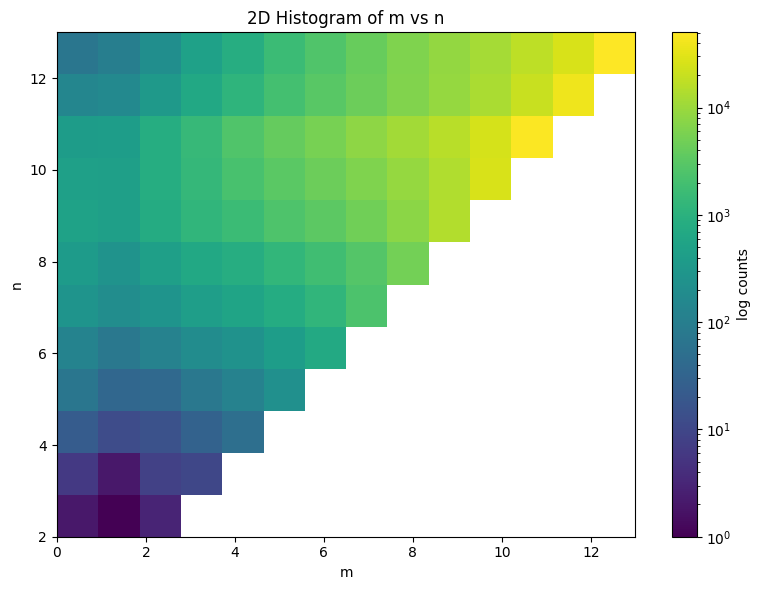

<Figure size 800x600 with 0 Axes>

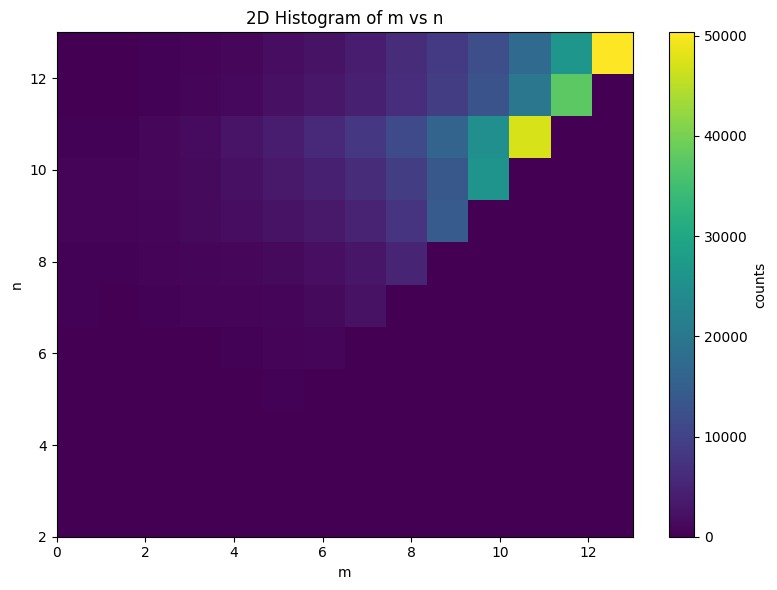

In [16]:
import matplotlib.pyplot as plt
from pcdd.noise_schedule.idlm import LogLinearNoiseSchedule
#noise_schedule = LogLinearNoiseSchedule(sigma_min=10, sigma_max=12)
noise_schedule = LogLinearNoiseSchedule(sigma_min=1, sigma_max=20)

t = torch.linspace(1e-3, 1.0, 1000)
noise_rate, total_noise = noise_schedule(t)

plt.plot(t, noise_rate, label='noise_rate')
plt.plot(t, total_noise, label='total_noise')
ratio = (noise_rate/total_noise)
plt.plot(t, ratio, label='noise_rate/total_noise', color='red', linestyle='--')
plt.yscale('log')
plt.legend()
plt.show()

plt.plot(t, noise_rate, label='noise_rate')
plt.plot(t, total_noise, label='total_noise')
plt.plot(t, (noise_rate/(total_noise )), label='noise_rate/total_noise', color='red', linestyle='--')
plt.legend()
plt.show()
print(ratio[0])
print(ratio[len(ratio)//2])
print(ratio[-1])

t = noise_schedule.sample_t(len(lengths))
noise_rate, total_noise = noise_schedule(t)
n_drops = torch.poisson(total_noise)
m = torch.maximum(lengths_tensor - n_drops, torch.tensor([0]))



plt.figure(figsize=(10, 6))
plt.hist(lengths_tensor.numpy(), bins=22, color="skyblue", edgecolor="black")
plt.xlabel("n")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(n_drops.numpy(), bins=int(n_drops.max().item()), color="skyblue", edgecolor="black")
plt.xlabel("Num drops")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

print(f"Fraction with zero drops: {torch.sum(n_drops == 0).item()/len(n_drops)}")

plt.figure(figsize=(10, 6))
plt.hist(m.numpy(), bins=22, color="skyblue", edgecolor="black")
plt.xlabel("m")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


y = lengths_tensor.detach().cpu().numpy()
x = m.detach().cpu().numpy()

# 3a. Using hist2d
from matplotlib.colors import LogNorm
plt.figure(figsize=(8,6))
hb = plt.hist2d(x, y, bins=[int(max(x)-min(x)+1), int(max(y)-min(y)+1)], norm=LogNorm(vmin=1))
plt.colorbar(hb[3], label='log counts')
plt.xlabel('m')
plt.ylabel('n')
plt.title('2D Histogram of m vs n')
plt.tight_layout()
plt.show()


# 3a. Using hist2d
from matplotlib.colors import LogNorm
plt.figure(figsize=(8,6))
plt.figure(figsize=(8,6))
hb = plt.hist2d(x, y, bins=[int(max(x)-min(x)+1), int(max(y)-min(y)+1)])
plt.colorbar(hb[3], label='counts')
plt.xlabel('m')
plt.ylabel('n')
plt.title('2D Histogram of m vs n')
plt.tight_layout()
plt.show()

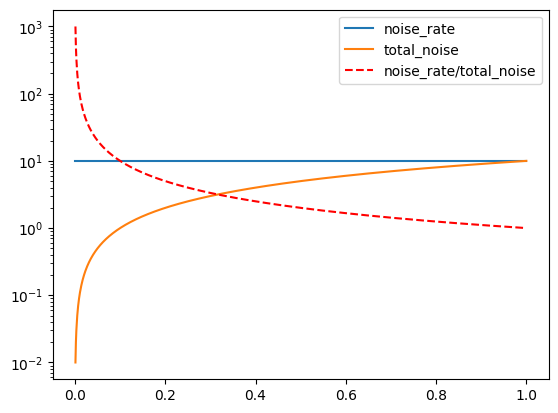

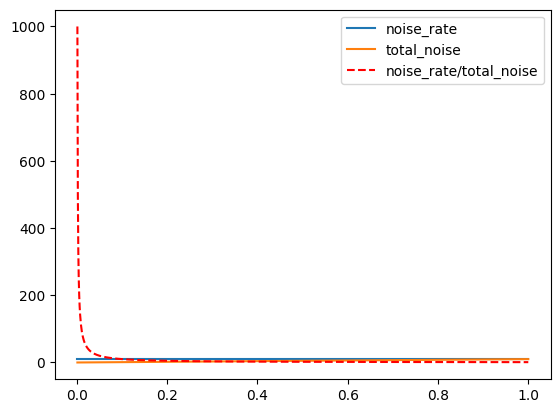

tensor(999.9999)
tensor(1.9960)
tensor(1.)


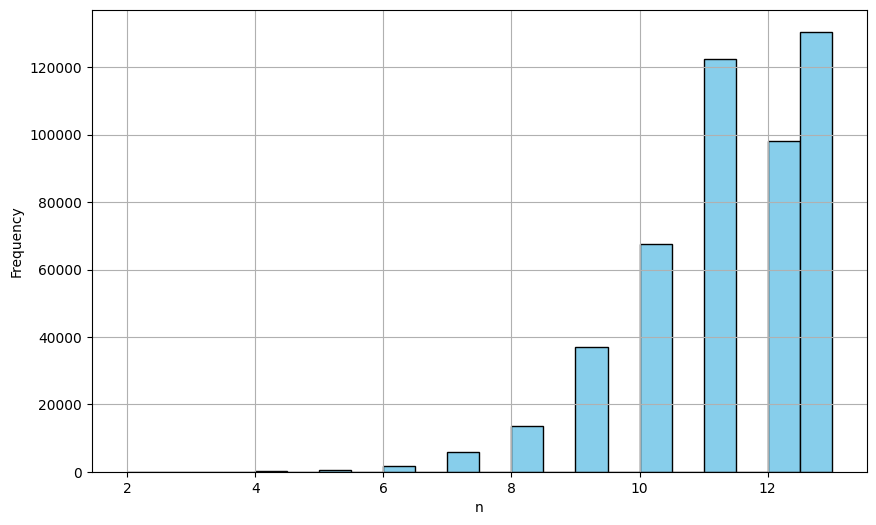

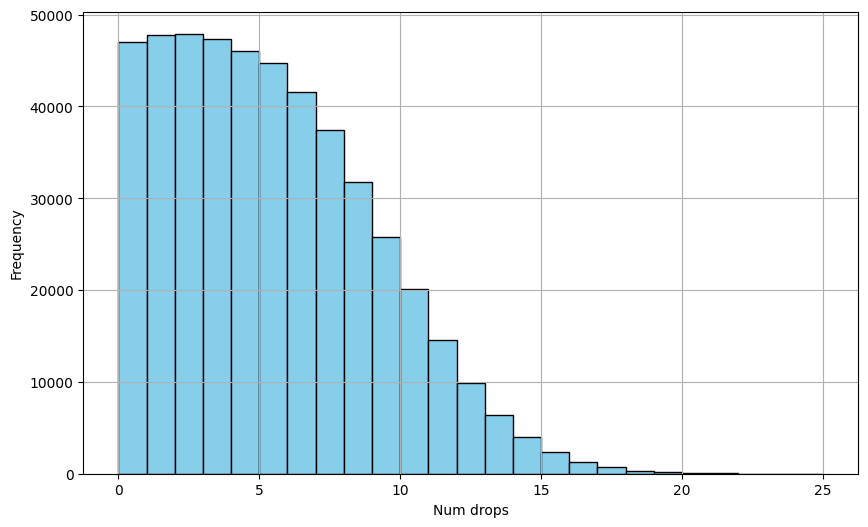

Fraction with zero drops: 0.09853912934203224


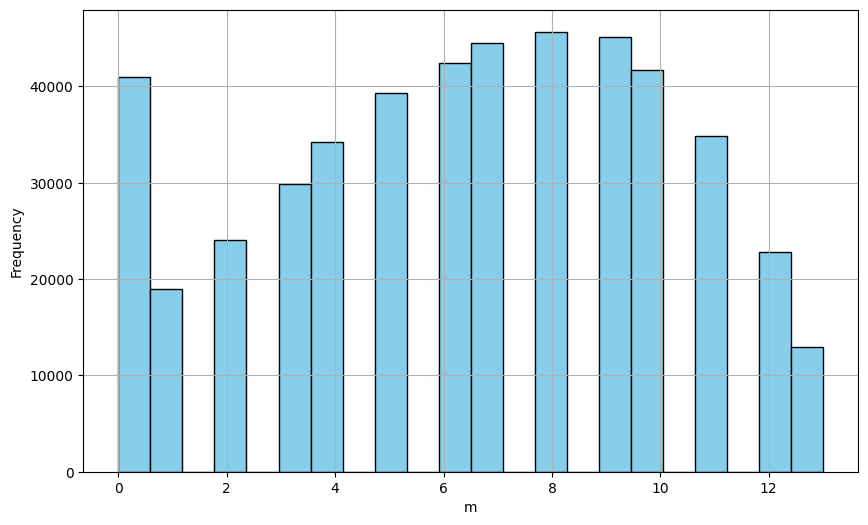

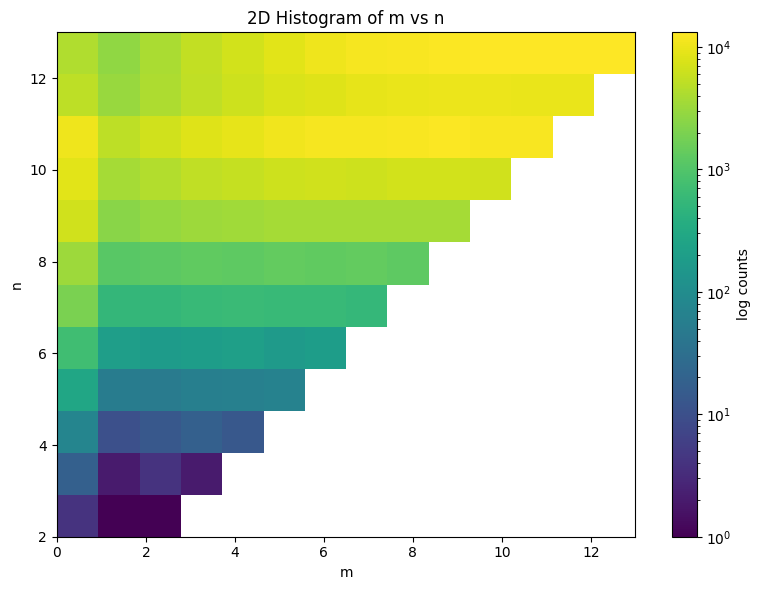

<Figure size 800x600 with 0 Axes>

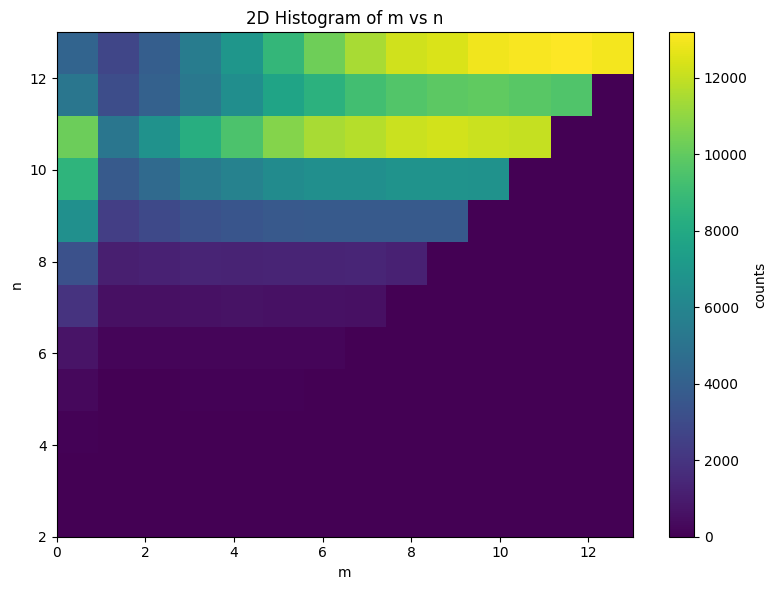

In [21]:
import matplotlib.pyplot as plt
from pcdd.noise_schedule.idlm import LogLinearNoiseSchedule, PoissonNoiseSchedule
#noise_schedule = LogLinearNoiseSchedule(sigma_min=10, sigma_max=12)
eps = 1e-3
noise_schedule = PoissonNoiseSchedule(sigma=10, eps=eps)

t = torch.linspace(eps, 1.0, 1000)
noise_rate, total_noise = noise_schedule(t)

plt.plot(t, noise_rate, label='noise_rate')
plt.plot(t, total_noise, label='total_noise')
ratio = (noise_rate/total_noise)
plt.plot(t, ratio, label='noise_rate/total_noise', color='red', linestyle='--')
plt.yscale('log')
plt.legend()
plt.show()

plt.plot(t, noise_rate, label='noise_rate')
plt.plot(t, total_noise, label='total_noise')
plt.plot(t, (noise_rate/(total_noise )), label='noise_rate/total_noise', color='red', linestyle='--')
plt.legend()
plt.show()
print(ratio[0])
print(ratio[len(ratio)//2])
print(ratio[-1])

t = noise_schedule.sample_t(len(lengths))
noise_rate, total_noise = noise_schedule(t)
n_drops = torch.poisson(total_noise)
m = torch.maximum(lengths_tensor - n_drops, torch.tensor([0]))



plt.figure(figsize=(10, 6))
plt.hist(lengths_tensor.numpy(), bins=22, color="skyblue", edgecolor="black")
plt.xlabel("n")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(n_drops.numpy(), bins=int(n_drops.max().item()), color="skyblue", edgecolor="black")
plt.xlabel("Num drops")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

print(f"Fraction with zero drops: {torch.sum(n_drops == 0).item()/len(n_drops)}")

plt.figure(figsize=(10, 6))
plt.hist(m.numpy(), bins=22, color="skyblue", edgecolor="black")
plt.xlabel("m")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


y = lengths_tensor.detach().cpu().numpy()
x = m.detach().cpu().numpy()

# 3a. Using hist2d
from matplotlib.colors import LogNorm
plt.figure(figsize=(8,6))
hb = plt.hist2d(x, y, bins=[int(max(x)-min(x)+1), int(max(y)-min(y)+1)], norm=LogNorm(vmin=1))
plt.colorbar(hb[3], label='log counts')
plt.xlabel('m')
plt.ylabel('n')
plt.title('2D Histogram of m vs n')
plt.tight_layout()
plt.show()


# 3a. Using hist2d
from matplotlib.colors import LogNorm
plt.figure(figsize=(8,6))
plt.figure(figsize=(8,6))
hb = plt.hist2d(x, y, bins=[int(max(x)-min(x)+1), int(max(y)-min(y)+1)])
plt.colorbar(hb[3], label='counts')
plt.xlabel('m')
plt.ylabel('n')
plt.title('2D Histogram of m vs n')
plt.tight_layout()
plt.show()

In [6]:
lens = "for 

Dataset({
    features: ['text'],
    num_rows: 477455
})

In [8]:
lengths[0]

{'text': 'my small elephant `s my sad telescope thought that the sad telescope laughed'}

# OWT

In [2]:
import datasets

In [3]:
tokenized = datasets.load_from_disk('/scratch3/workspace/dhruveshpate_umass_edu-text_diffusion/data/dhruveshpatel/owt-gpt2-1024-split/train')
def length(example):
    example["length"] = len(example["token_ids"])
    return example
lengths = tokenized.map(length, batched=False, num_proc=8)

Loading dataset from disk:   0%|          | 0/120 [00:00<?, ?it/s]

Map (num_proc=8):   0%|          | 0/5329817 [00:00<?, ? examples/s]

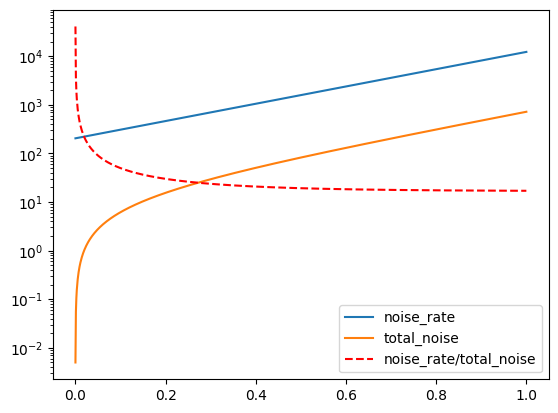

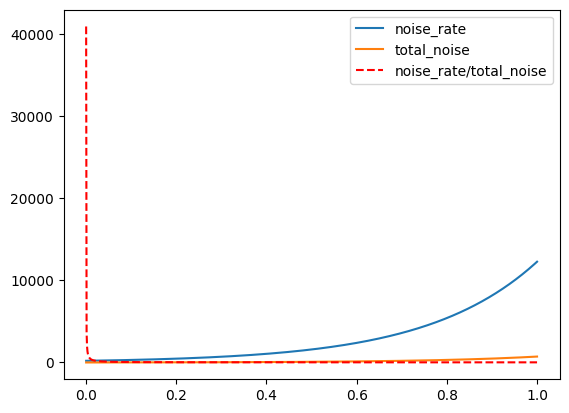

tensor(40955.2656)
tensor(19.2422)
tensor(17.0478)


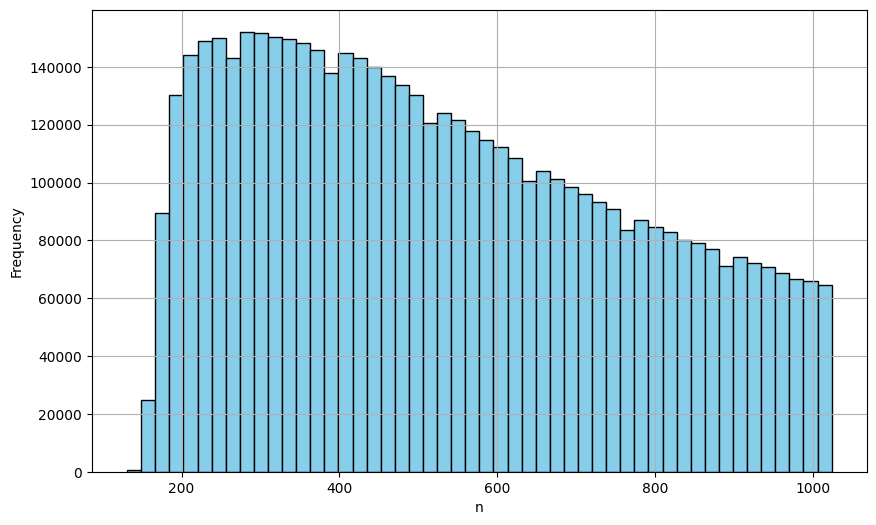

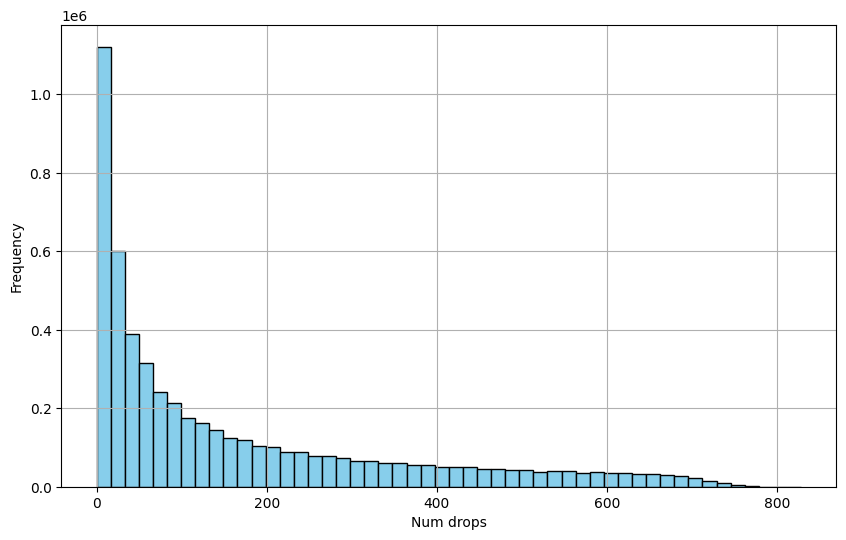

Fraction with zero drops: 0.01855091835235619


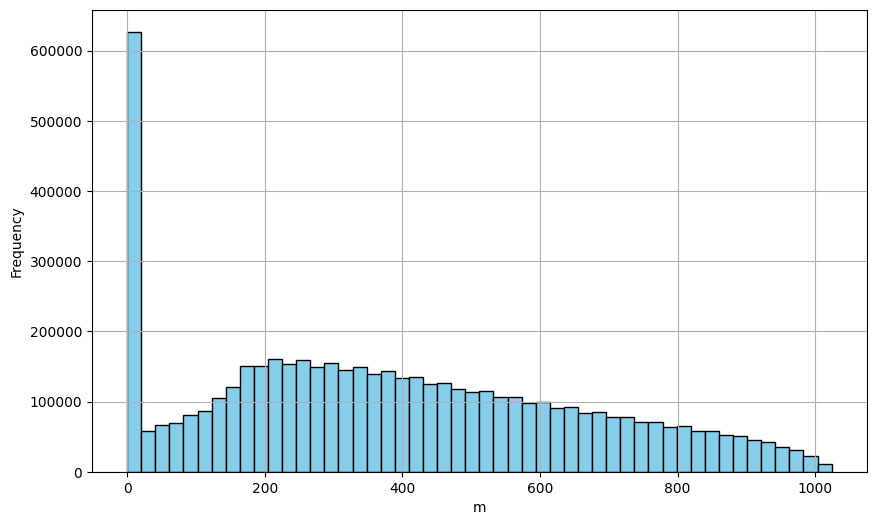

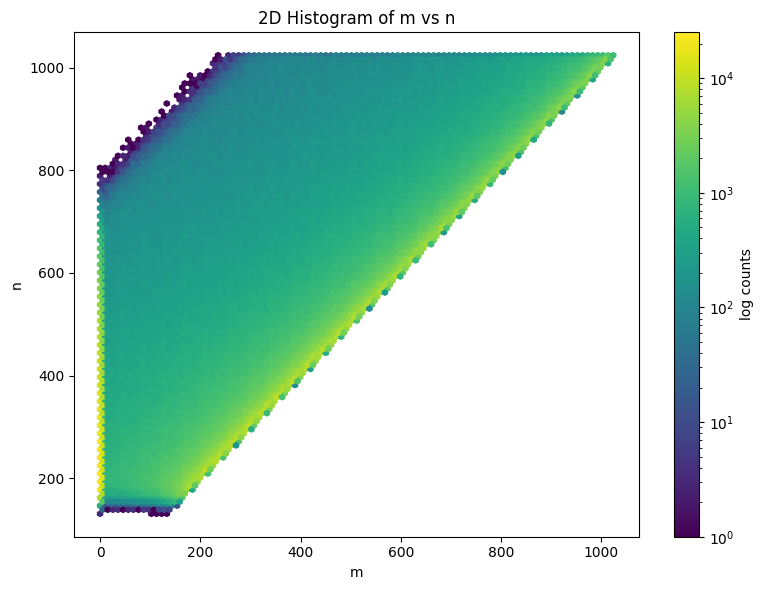

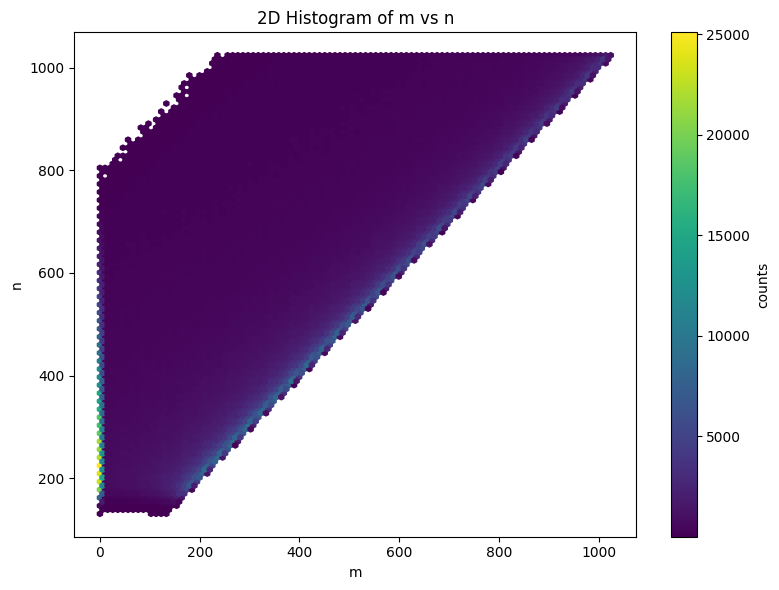

Fraction with m=0: 0.10759900510311127
max wt: 40955.265625, total_noise: 0.005000603850930929, n: 179, m: 178.0, S_: 1.0000277757644653
min wt: 3.855382809878072e-13
min wt: 3.855382809878072e-13, total_noise: 719.2618408203125, n: 141, m: 0.0, S_: 44219418804224.0


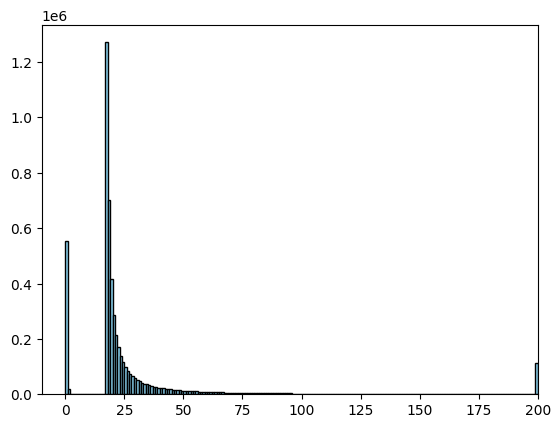

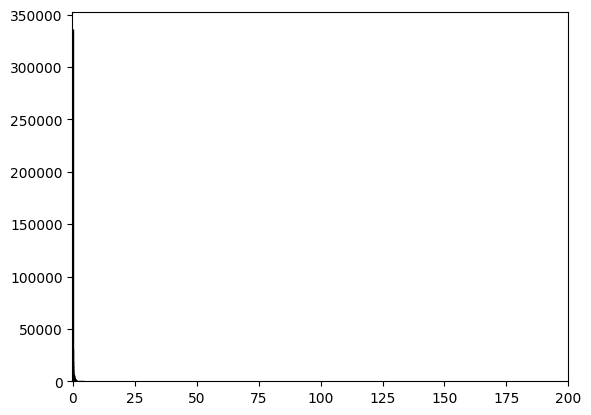

In [22]:
import matplotlib.pyplot as plt
from xlm.lm.idlm.noise_schedule import (
    LogLinearNoiseSchedule,
)
from xlm.lm.idlm.nn import hyp1f1_1_nplus1_vec
import torch
eps = 1e-4
#eps = 1e-3
noise_schedule = LogLinearNoiseSchedule(sigma_min=50, sigma_max=3000, eps=eps)
t = torch.linspace(eps, 1.0, 1000)
noise_rate, total_noise = noise_schedule(t)
plt.plot(t, noise_rate, label="noise_rate")
plt.plot(t, total_noise, label="total_noise")
ratio = noise_rate / total_noise
plt.plot(t, ratio, label="noise_rate/total_noise", color="red", linestyle="--")
plt.yscale("log")
plt.legend()
plt.show()

plt.plot(t, noise_rate, label="noise_rate")
plt.plot(t, total_noise, label="total_noise")
plt.plot(t, ratio, label="noise_rate/total_noise", color="red", linestyle="--")
plt.legend()
plt.show()
print(ratio[0])
print(ratio[len(ratio) // 2])
print(ratio[-1])


t = noise_schedule.sample_t(len(lengths))
noise_rate, total_noise = noise_schedule(t)
ratio = noise_rate / total_noise
n_drops = torch.poisson(total_noise)
lengths_tensor = torch.tensor(lengths["length"])
m = torch.maximum(lengths_tensor - n_drops, torch.tensor([0]))


plt.figure(figsize=(10, 6))
plt.hist(lengths_tensor.numpy(), bins=50, color="skyblue", edgecolor="black")
plt.xlabel("n")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(n_drops.numpy(), bins=50, color="skyblue", edgecolor="black")
plt.xlabel("Num drops")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

print(
    f"Fraction with zero drops: {torch.sum(n_drops == 0).item()/len(n_drops)}"
)

plt.figure(figsize=(10, 6))
plt.hist(m.numpy(), bins=50, color="skyblue", edgecolor="black")
plt.xlabel("m")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


y = lengths_tensor.detach().cpu().numpy()
x = m.detach().cpu().numpy()

# 3a. Using hist2d
from matplotlib.colors import LogNorm

plt.figure(figsize=(8, 6))
# hb = plt.hist2d(x, y, bins=100, norm=LogNorm(vmin=1))    # you can tweak bins
# plt.colorbar(hb[3], label='counts')
hb = plt.hexbin(x, y, gridsize=100, bins="log", mincnt=1)
plt.colorbar(hb, label="log counts")
plt.xlabel("m")
plt.ylabel("n")
plt.title("2D Histogram of m vs n")
plt.tight_layout()
plt.show()


# 3a. Using hist2d
from matplotlib.colors import LogNorm

plt.figure(figsize=(8, 6))
# hb = plt.hist2d(x, y, bins=100, norm=LogNorm(vmin=1))    # you can tweak bins
# plt.colorbar(hb[3], label='counts')
hb = plt.hexbin(x, y, gridsize=100, mincnt=1)
plt.colorbar(hb, label="counts")
plt.xlabel("m")
plt.ylabel("n")
plt.title("2D Histogram of m vs n")
plt.tight_layout()
plt.show()


S_ = hyp1f1_1_nplus1_vec(total_noise, lengths_tensor, K=20)
mask = m == 0
print(f"Fraction with m=0: {mask.sum()/len(mask)}")
S = torch.where(mask, S_, 1.0)
wt = ratio / S
max_wt, max_wt_idx = wt.max(), wt.argmax()
print(
    f"max wt: {max_wt}, total_noise: {total_noise[max_wt_idx]}, n: {lengths_tensor[max_wt_idx]}, m: {m[max_wt_idx]}, S_: {S_[max_wt_idx]}"
)
min_wt, min_wt_idx = wt.min(), wt.argmin()
print(f"min wt: {min_wt}")
print(f"min wt: {min_wt}, total_noise: {total_noise[min_wt_idx]}, n: {lengths_tensor[min_wt_idx]}, m: {m[min_wt_idx]}, S_: {S_[min_wt_idx]}")
max_value = 200  # Define the max value for the x-axis
wt_clipped = torch.clamp(wt, max=max_value)  # Clip the values at max_value
plt.hist(
    wt_clipped.numpy(), bins=max_value, color="skyblue", edgecolor="black"
)
plt.xlim(right=max_value)  # Set the x-axis limit to max_value
plt.show()

# plot wt only for m=0
plt.hist(wt[mask].numpy(), bins=max_value, color="skyblue", edgecolor="black")
plt.xlim(right=max_value)  # Set the x-axis limit to max_value
plt.show()